# Train Rides

In [2]:
import importlib
import parser
import util
from scapy.all import rdpcap
from scapy.layers.dot11 import Dot11
from scapy.packet import Packet
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib import font_manager
from datetime import datetime, timedelta
import csv
import pickle
import numpy as np
from scipy import signal, ndimage

In [3]:
importlib.reload(util)
importlib.reload(parser)

<module 'parser' from '/home/erdem/school/master/semester-4/in2324-connected-mobility-basics/connected-mobility-basics-group-7/assignment-2/analysis/parser.py'>

In [4]:
captures_dir = Path("../captures")
captures_paths = list(captures_dir.glob("*.pcap"))

In [5]:
scenarios = {
    "train-peak-campus-kieferngarten": {
        "date": "2025-07-04",
    },
    "train-peak-kieferngarten-campus": {
        "date": "2025-07-04",
    },
    "train-offpeak-campus-kieferngarten": {
        "date": "2025-07-06",
    },
    "train-offpeak-kieferngarten-campus": {
        "date": "2025-07-06",
    }
}
channels = [1, 6, 11]
known_macs = {
    "28:DF:EB:53:A0:25".lower(): "Controller Laptop",
    "28:C2:1F:E6:52:91".lower(): "Smartphone",
    "B8:27:EB:D4:9F:FB".lower(): "Raspberry Pi"
}

In [6]:
for scenario in scenarios:
    print(f"Processing {scenario}...")
    pkl_path = Path(f"packets-train/{scenario}.pkl")
    if not pkl_path.exists():
        pcaps = {
            channel: parser.PcapParser(captures_dir / f"{scenarios[scenario]["date"]}/{scenario}-c{channel}.pcap") for channel in channels
        }
        packets = {
            channel: [
                {
                    "time": packet.time,
                    "dBm_AntSignal": getattr(packet, "dBm_AntSignal", None),
                    "channel": channel,
                    "src_mac": getattr(packet, "addr2", None),
                    "dst_mac": getattr(packet, "addr1", None),
                    "bssid": getattr(packet, "addr3", None),
                    "SSID": getattr(packet, "info", None) if hasattr(packet, "info") else None,
                    "type": getattr(packet, "type", None),
                    "subtype": getattr(packet, "subtype", None),
                    "SC": getattr(packet, "SC", None),
                    "antenna": getattr(packet, "Antenna", None),
                    "rate": getattr(packet, "Rate", None),
                    "len": len(packet)
                }
                for packet in pcaps[channel].filtered_packets
            ]
            for channel in channels
        }
        with open(pkl_path, "wb") as f:
            pickle.dump(packets, f)
packets = {
    label: pickle.load(open(f"packets-train/{label}.pkl", "rb"))
    for label in scenarios
}

Processing train-peak-campus-kieferngarten...
Processing train-peak-kieferngarten-campus...
Processing train-offpeak-campus-kieferngarten...
Processing train-offpeak-kieferngarten-campus...


In [7]:
timetables = {scenario: util.parse_timetable(captures_dir / f"{scenarios[scenario]["date"]}/{scenario}.csv") for scenario in scenarios.keys()}

## Time Tables

train-peak-campus-kieferngarten
train-peak-kieferngarten-campus
train-offpeak-campus-kieferngarten
train-offpeak-kieferngarten-campus


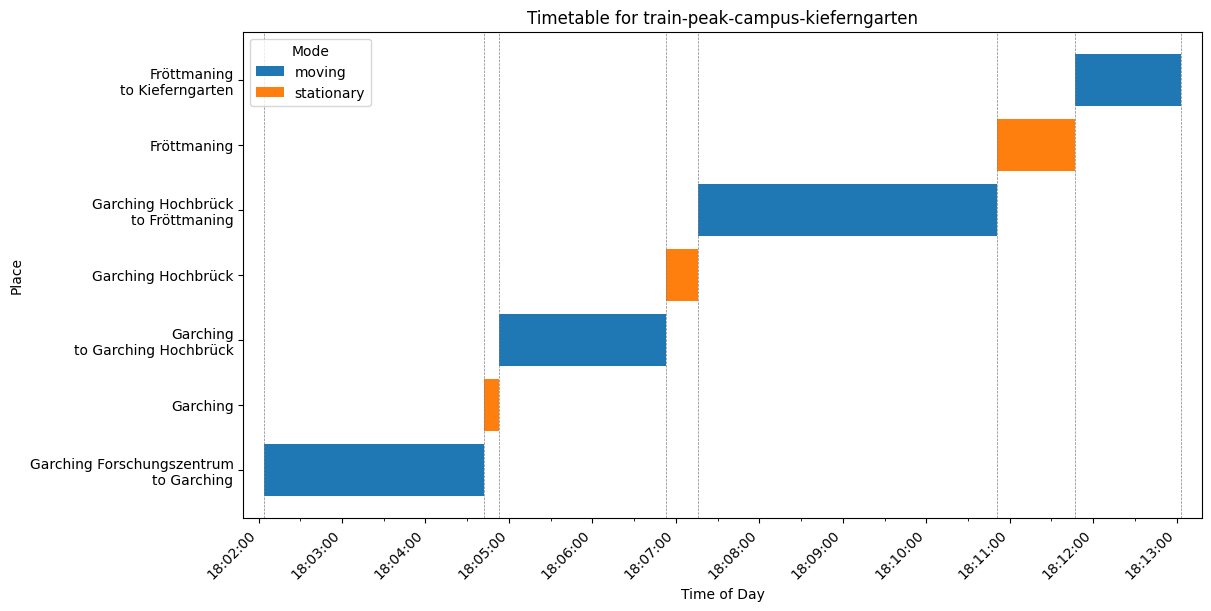

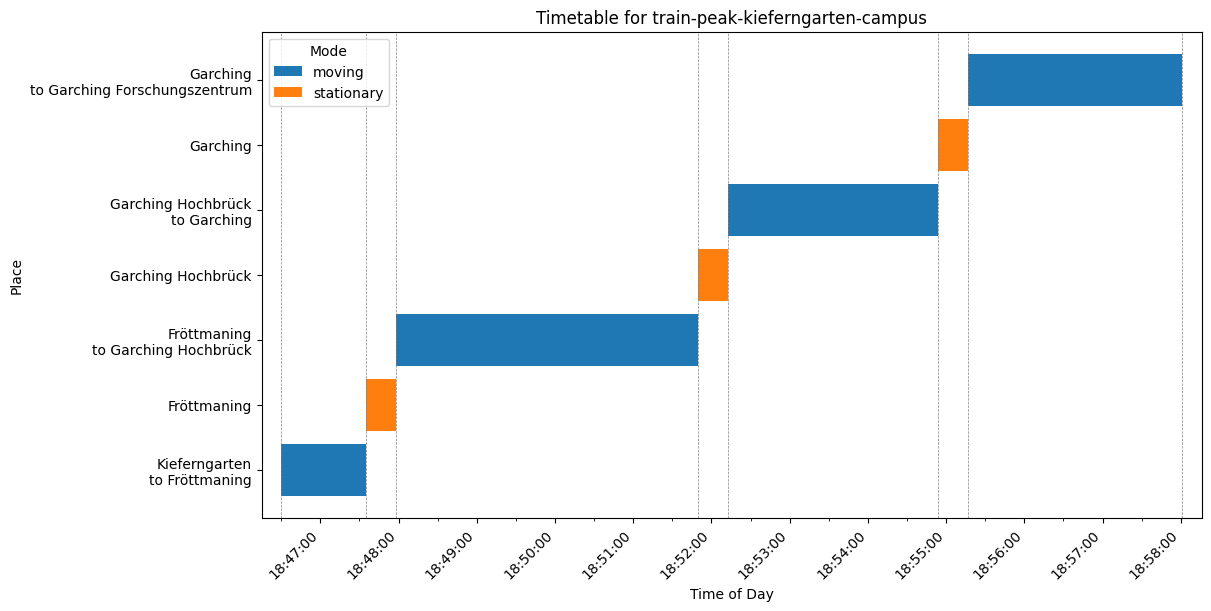

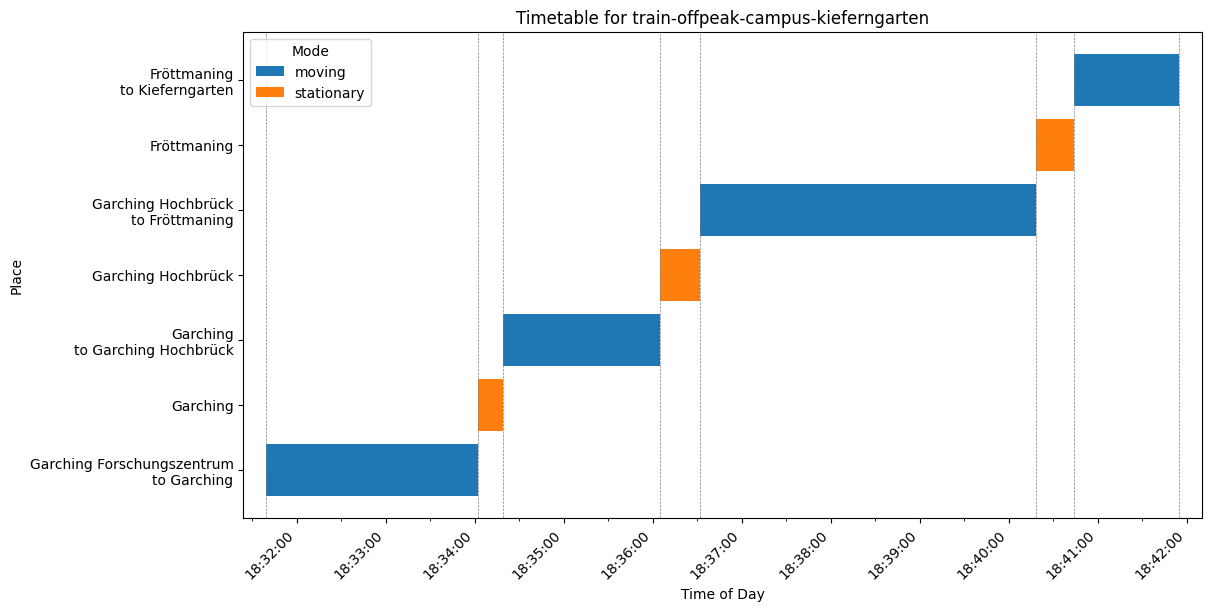

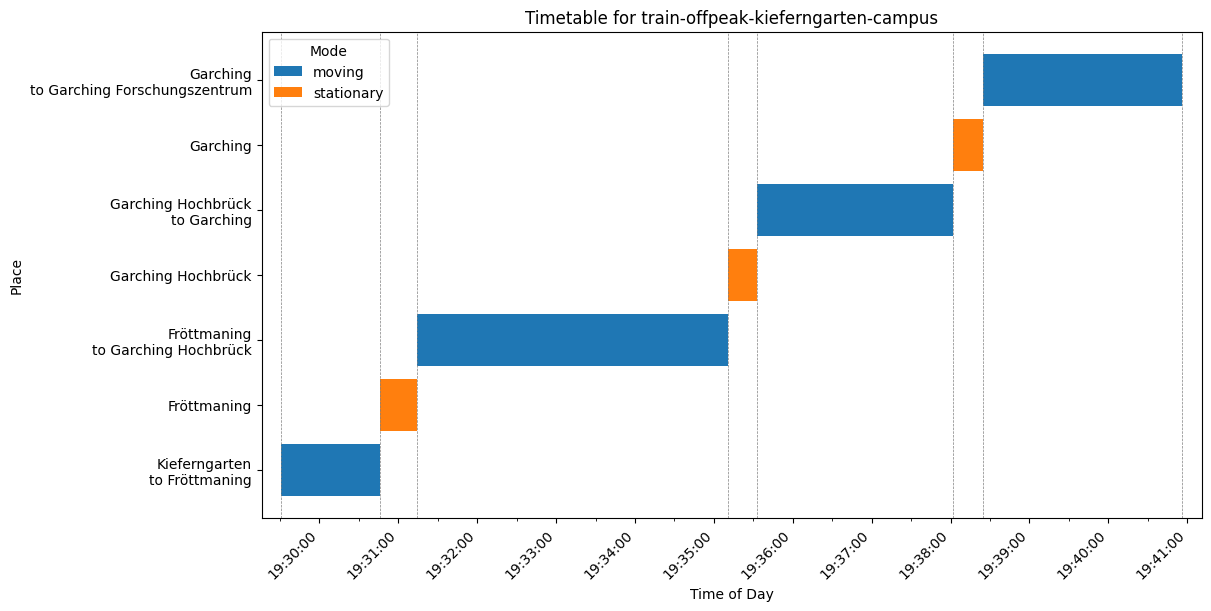

In [ ]:
colors = {"stationary": "tab:orange", "moving": "tab:blue"}

for (scenario, timetable) in timetables.items():
    first_packet_time = float(min([pkt["time"] for ch in channels for pkt in packets[scenario][ch]]))
    last_packet_time = float(max([pkt["time"] for ch in channels for pkt in packets[scenario][ch]]))
    first_dt = datetime.fromtimestamp(first_packet_time)
    last_dt = datetime.fromtimestamp(last_packet_time)

    timetable[0]["start"] = first_dt.strftime("%H:%M:%S")
    timetable[-1]["end"] = last_dt.strftime("%H:%M:%S")

    fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
    ax.set_title(f"Timetable for {scenario}")

    for entry in timetable:
        start_time = datetime.strptime(entry["start"], "%H:%M:%S")
        end_time = datetime.strptime(entry["end"], "%H:%M:%S")
        duration = (end_time - start_time)
        ax.barh(
            y=entry["place"],
            width=duration,
            left=start_time,
            color=colors[entry["mode"]],
            label=entry["mode"] if entry["mode"] not in ax.get_legend_handles_labels()[1] else ""
        )
        if entry is timetable[0]:
            ax.axvline(x=start_time, color="gray", linestyle="--", linewidth=0.5)
        ax.axvline(x=end_time, color="gray", linestyle="--", linewidth=0.5)

    offset = timedelta(seconds=15)
    plot_start = datetime.strptime(timetable[0]["start"], "%H:%M:%S") - offset
    plot_end = datetime.strptime(timetable[-1]["end"], "%H:%M:%S") + offset
    ax.set_xlim(plot_start, plot_end)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=[0, 30]))

    for scenario_label in ax.get_xticklabels():
        scenario_label.set_rotation(45)
        scenario_label.set_ha("right")

    yticks = ax.get_yticks()
    yticklabels = [label.get_text().replace('\\n', '\n') for label in ax.get_yticklabels()]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.legend(title="Mode", loc="upper left")
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Place")

    plt.savefig(f"../report/images/part1/timetables/timetable-{scenario}.png", dpi=300, bbox_inches="tight")

In [9]:
channel_times = {scenario: {channel: [] for channel in channels} for scenario in scenarios.keys()}

for scenario in scenarios.keys():
    for channel in channels:
        channel_times[scenario][channel] = [packet["time"] for packet in packets[scenario][channel]]


In [10]:
def get_packet_count_stats(packets, scenario, channel=None):
    if channel is not None:
        return len(packets[scenario][channel])
    return sum(len(packets[scenario][ch]) for ch in channels)

def get_mac_stats(packets, scenario, channel=None):
    random_macs = set()
    global_macs = set()
    chs = [channel] if channel is not None else channels
    for ch in chs:
        for packet in packets[scenario][ch]:
            src_mac = packet["src_mac"]
            if src_mac and util.is_random(src_mac):
                random_macs.add(src_mac)
            elif src_mac and not util.is_random(src_mac):
                global_macs.add(src_mac)
    return {
        "random_macs": len(random_macs),
        "global_macs": len(global_macs)
    }

def get_ssid_stats(packets, scenario, channel=None):
    ssid_set_count = 0
    chs = [channel] if channel is not None else channels
    for ch in chs:
        for packet in packets[scenario][ch]:
            ssid = packet["SSID"]
            if ssid is None:
                continue
            try:
                ssid = ssid.decode("utf-8")
            except UnicodeDecodeError:
                ssid = ssid.decode("latin1")
            if ssid != "":
                ssid_set_count += 1
    return ssid_set_count

for scenario in scenarios:
    print(f"Packet count stats for {scenario}:")
    total_packets = get_packet_count_stats(packets, scenario)
    print(f"  Total: {total_packets}")
    for channel in channels:
        print(f"  Channel {channel}: {get_packet_count_stats(packets, scenario, channel)}")
    print()

    print(f"MAC stats for {scenario}:")
    mac_stats_total = get_mac_stats(packets, scenario)
    print(f"  Total Random MACs: {mac_stats_total['random_macs']}")
    print(f"  Total Global MACs: {mac_stats_total['global_macs']}")
    for channel in channels:
        mac_stats = get_mac_stats(packets, scenario, channel)
        print(f"  Channel {channel} Random MACs: {mac_stats['random_macs']}")
        print(f"  Channel {channel} Global MACs: {mac_stats['global_macs']}")
    print()

    print(f"SSID stats for {scenario}:")
    ssid_stats_total = get_ssid_stats(packets, scenario)
    print(f"  Total packets with SSID set: {ssid_stats_total}")
    for channel in channels:
        ssid_stats = get_ssid_stats(packets, scenario, channel)
        print(f"  Channel {channel} packets with SSID set: {ssid_stats}")
    print(f"  Total packets with SSID not set: {total_packets - ssid_stats_total}")
    for channel in channels:
        ch_total = get_packet_count_stats(packets, scenario, channel)
        ch_ssid = get_ssid_stats(packets, scenario, channel)
        print(f"  Channel {channel} packets with SSID not set: {ch_total - ch_ssid}")
    print()

Packet count stats for train-peak-campus-kieferngarten:
  Total: 7654
  Channel 1: 2649
  Channel 6: 2558
  Channel 11: 2447

MAC stats for train-peak-campus-kieferngarten:
  Total Random MACs: 1976
  Total Global MACs: 11
  Channel 1 Random MACs: 1169
  Channel 1 Global MACs: 10
  Channel 6 Random MACs: 1056
  Channel 6 Global MACs: 7
  Channel 11 Random MACs: 1122
  Channel 11 Global MACs: 6

SSID stats for train-peak-campus-kieferngarten:
  Total packets with SSID set: 2387
  Channel 1 packets with SSID set: 841
  Channel 6 packets with SSID set: 826
  Channel 11 packets with SSID set: 720
  Total packets with SSID not set: 5267
  Channel 1 packets with SSID not set: 1808
  Channel 6 packets with SSID not set: 1732
  Channel 11 packets with SSID not set: 1727

Packet count stats for train-peak-kieferngarten-campus:
  Total: 1840
  Channel 1: 670
  Channel 6: 564
  Channel 11: 606

MAC stats for train-peak-kieferngarten-campus:
  Total Random MACs: 673
  Total Global MACs: 5
  Channe

## Probe Request Counts

### Cumulative Probe Request Counts

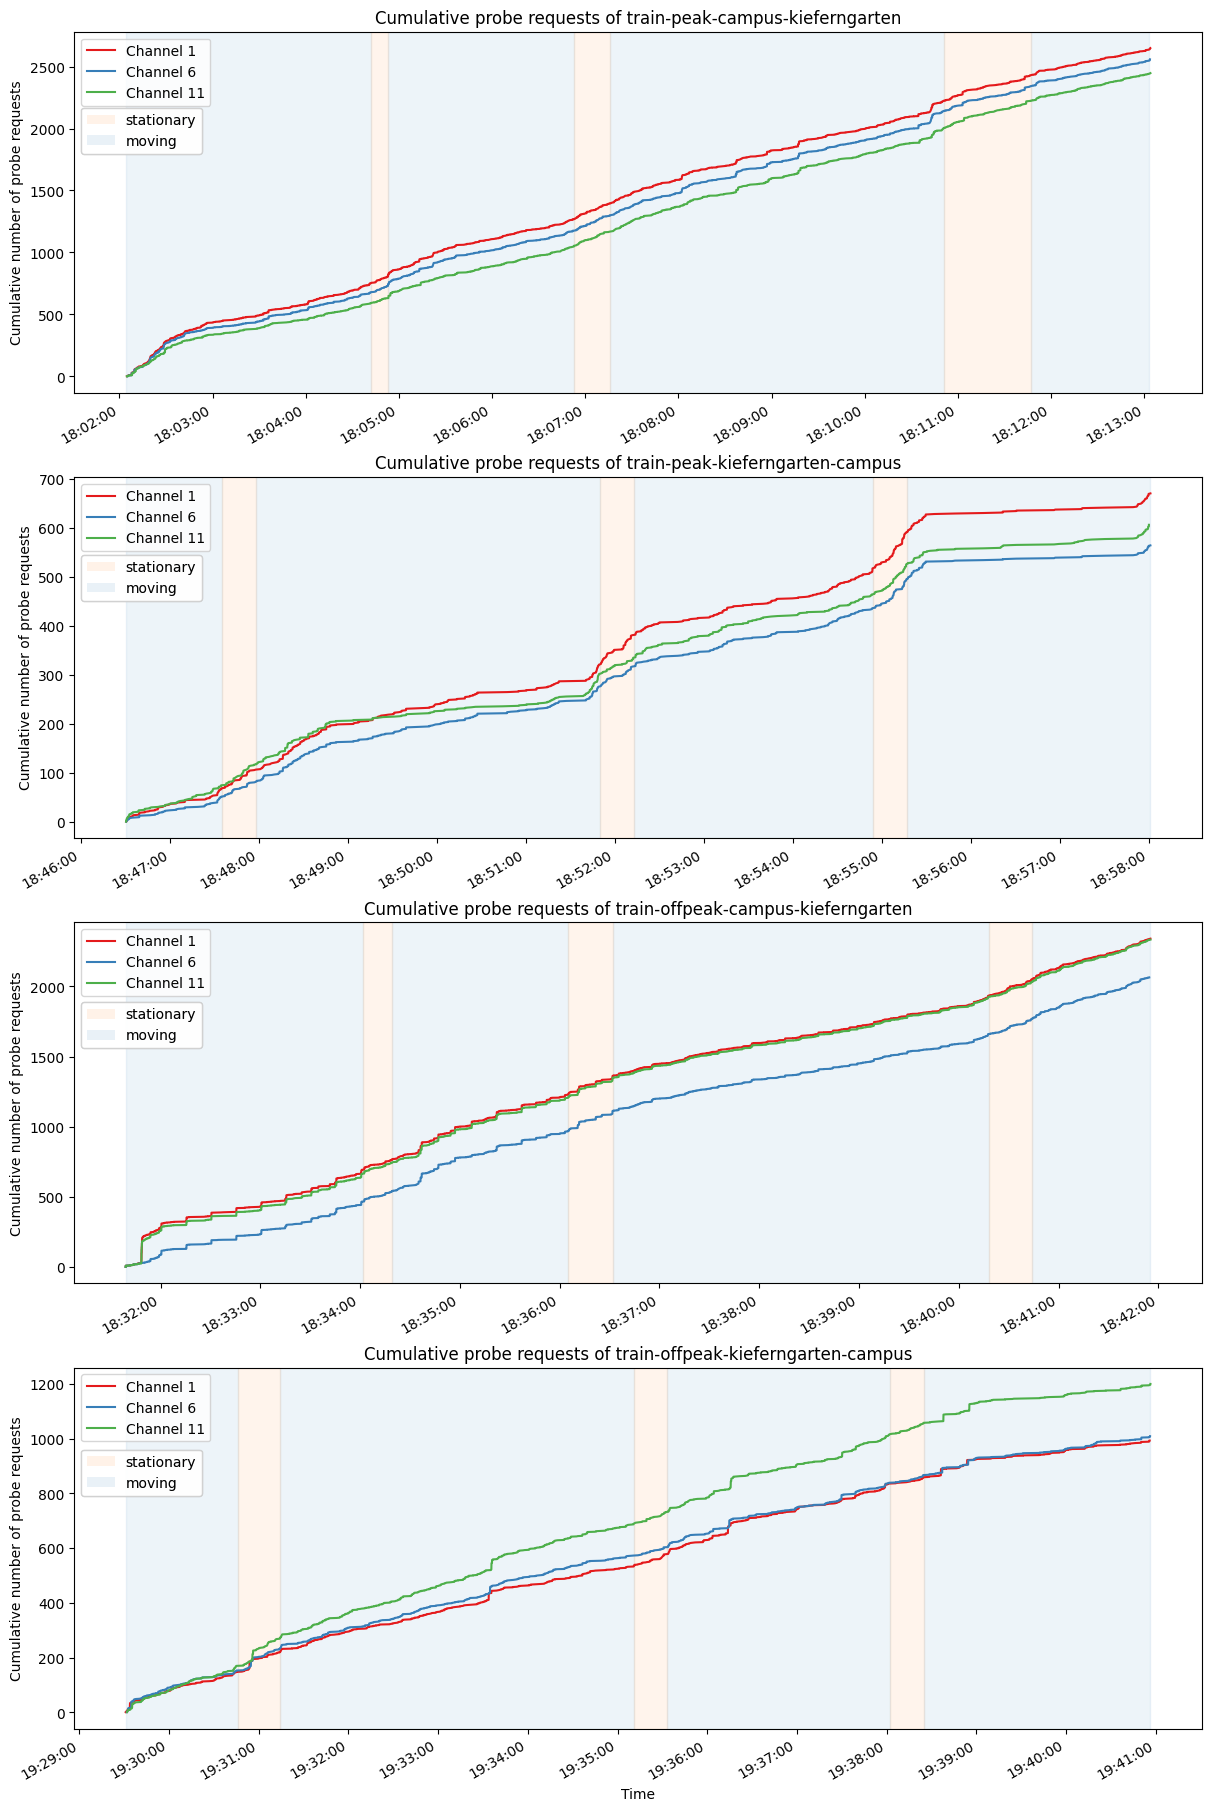

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(12, 18), constrained_layout=True, sharex=False)
for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    ax.set_prop_cycle(color=plt.cm.Set1.colors)
    date_base = datetime.strptime(scenarios[scenario]["date"], "%Y-%m-%d").date()
    data_lines = []
    for entry in timetables[scenario]:
        start_time = datetime.combine(date_base, datetime.strptime(entry["start"], "%H:%M:%S").time())
        end_time = datetime.combine(date_base, datetime.strptime(entry["end"], "%H:%M:%S").time())
        color = "tab:orange" if entry["mode"] == "stationary" else "tab:blue"
        ax.axvspan(start_time, end_time, color=color, alpha=0.08, zorder=0)
    for channel in channels:
        times = channel_times[scenario][channel]
        times_dt = [datetime.fromtimestamp(float(t)) for t in times]
        cumulative = list(range(1, len(times_dt) + 1))
        data_line = ax.plot(times_dt, cumulative, label=f'Channel {channel}', zorder=1)[0]
        data_lines.append(data_line)
    ax.set_title(f'Cumulative probe requests of {scenario}')
    ax.set_ylabel("Cumulative number of probe requests")
    data_legend = ax.legend(handles=data_lines, loc='upper left')
    ax.add_artist(data_legend)
    fig.canvas.draw()
    data_legend_box = data_legend.get_window_extent().transformed(ax.transAxes.inverted())
    data_legend_y = data_legend_box.y0
    mode_handles = [
        Patch(facecolor="tab:orange", alpha=0.08, label="stationary"),
        Patch(facecolor="tab:blue", alpha=0.08, label="moving"),
    ]
    mode_legend = ax.legend(handles=mode_handles, loc="upper left", bbox_to_anchor=(0, data_legend_y - 0.01))
    ax.add_artist(mode_legend)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks=100))
    for label_tick in ax.get_xticklabels():
        label_tick.set_rotation(30)
        label_tick.set_ha("right")
axes[-1].set_xlabel("Time")
plt.savefig("../report/images/part1/cumulative-packet-counts/train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

## Probe Requests Rate

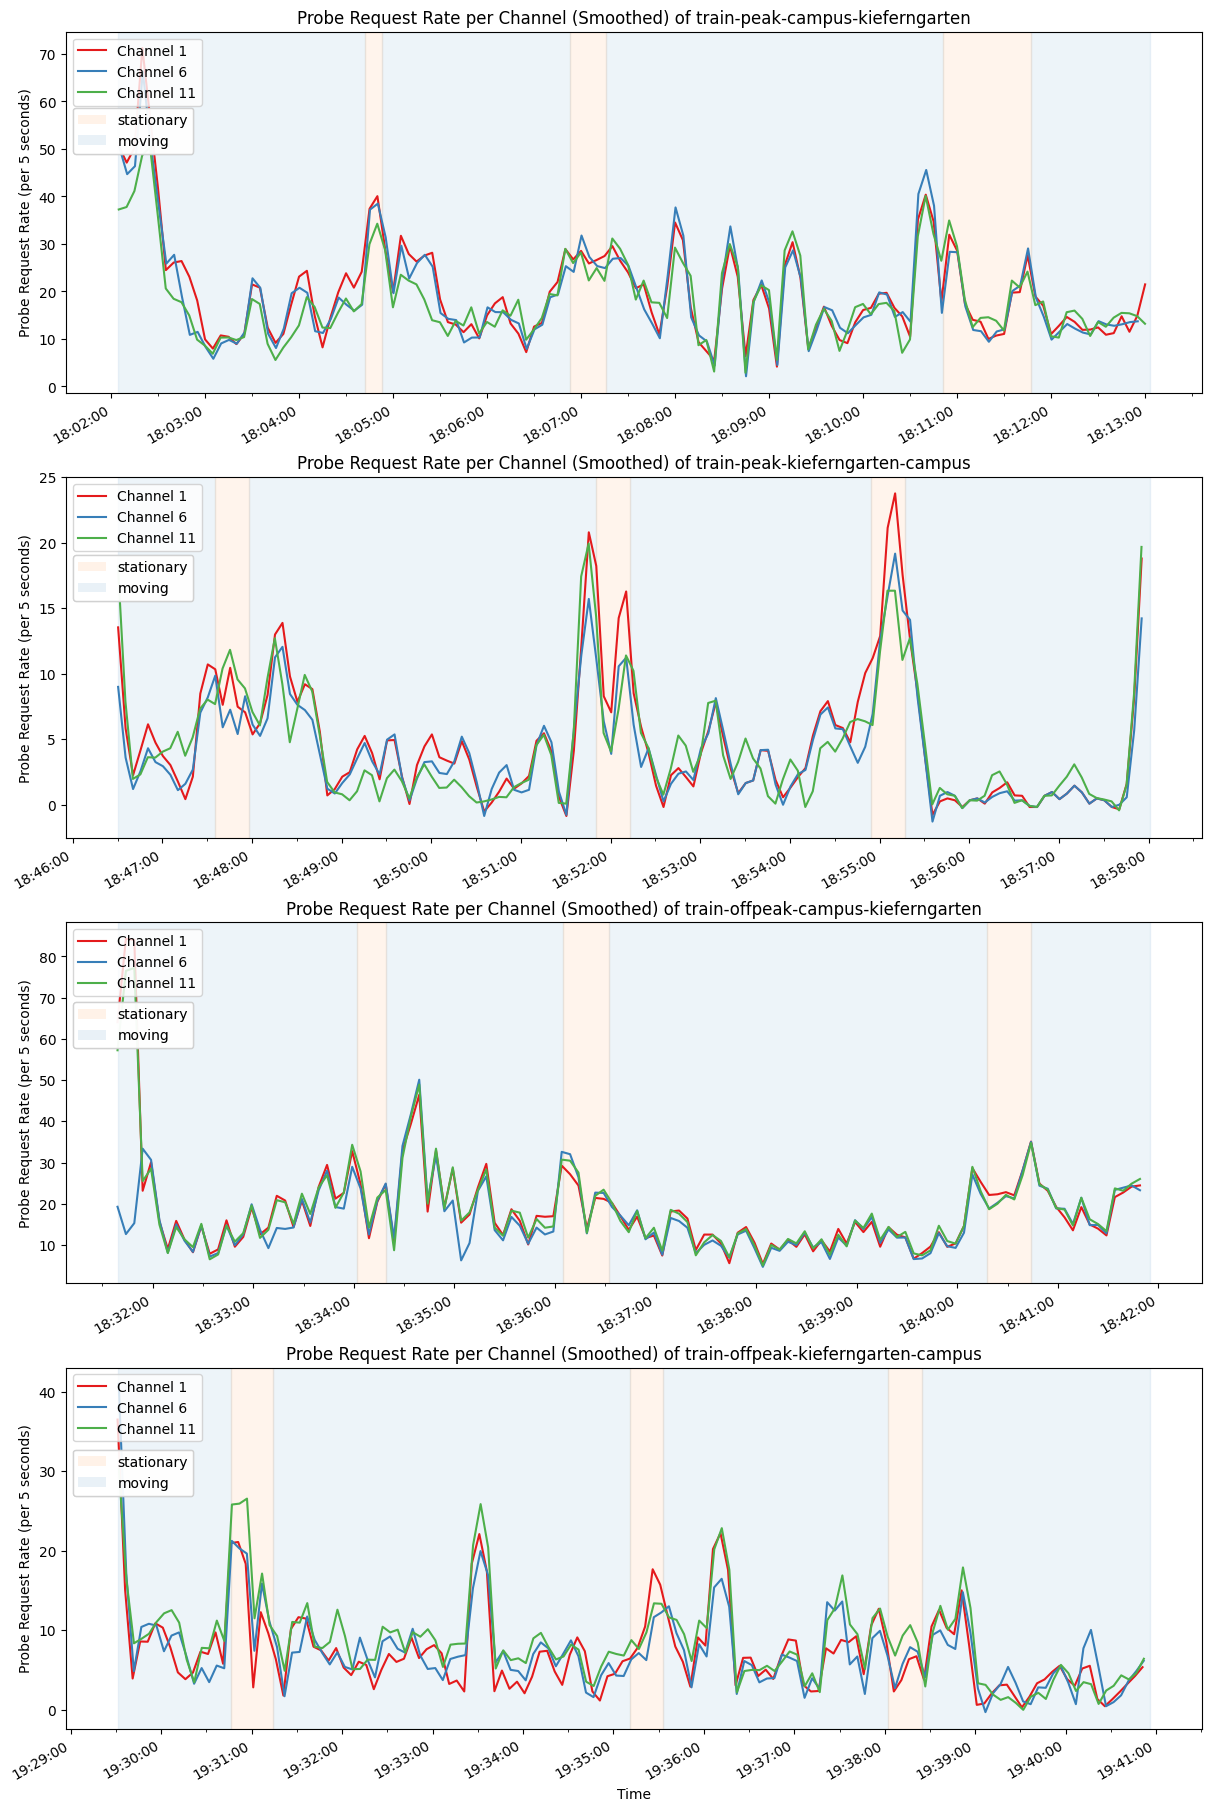

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(12, 18), constrained_layout=True, sharex=False)
for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    ax.set_prop_cycle(color=plt.cm.Set1.colors)
    date_base = datetime.strptime(scenarios[scenario]["date"], "%Y-%m-%d").date()
    data_lines = []
    for entry in timetables[scenario]:
        start_time = datetime.combine(date_base, datetime.strptime(entry["start"], "%H:%M:%S").time())
        end_time = datetime.combine(date_base, datetime.strptime(entry["end"], "%H:%M:%S").time())
        color = "tab:orange" if entry["mode"] == "stationary" else "tab:blue"
        ax.axvspan(start_time, end_time, color=color, alpha=0.08, zorder=0)
    for channel in channels:
        times = channel_times[scenario][channel]
        times_dt = [datetime.fromtimestamp(float(t)) for t in times]
        bin_edges = mdates.drange(times_dt[0], times_dt[-1] + timedelta(seconds=1), timedelta(seconds=5))
        hist, _ = np.histogram([mdates.date2num(t) for t in times_dt], bins=bin_edges)
        window = 5
        hist_smooth = signal.savgol_filter(hist, window_length=window, polyorder=2)
        data_line = ax.plot([mdates.num2date(e) for e in bin_edges[:-1]], hist_smooth, label=f'Channel {channel}', zorder=1)
        data_lines.append(data_line[0])
    ax.set_title(f'Probe Request Rate per Channel (Smoothed) of {scenario}')
    ax.set_ylabel("Probe Request Rate (per 5 seconds)")
    data_legend = ax.legend(handles=data_lines, loc='upper left')
    ax.add_artist(data_legend)
    fig.canvas.draw()
    data_legend_box = data_legend.get_window_extent().transformed(ax.transAxes.inverted())
    data_legend_y = data_legend_box.y0
    mode_handles = [
        Patch(facecolor="tab:orange", alpha=0.08, label="stationary"),
        Patch(facecolor="tab:blue", alpha=0.08, label="moving"),
    ]
    mode_legend = ax.legend(handles=mode_handles, loc="upper left", bbox_to_anchor=(0, data_legend_y - 0.01))
    ax.add_artist(mode_legend)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=[0, 30]))
    for label_tick in ax.get_xticklabels():
        label_tick.set_rotation(30)
        label_tick.set_ha("right")
axes[-1].set_xlabel("Time")
plt.savefig("../report/images/part1/probe-rate/train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

## RSSI

### RSSI Distribution

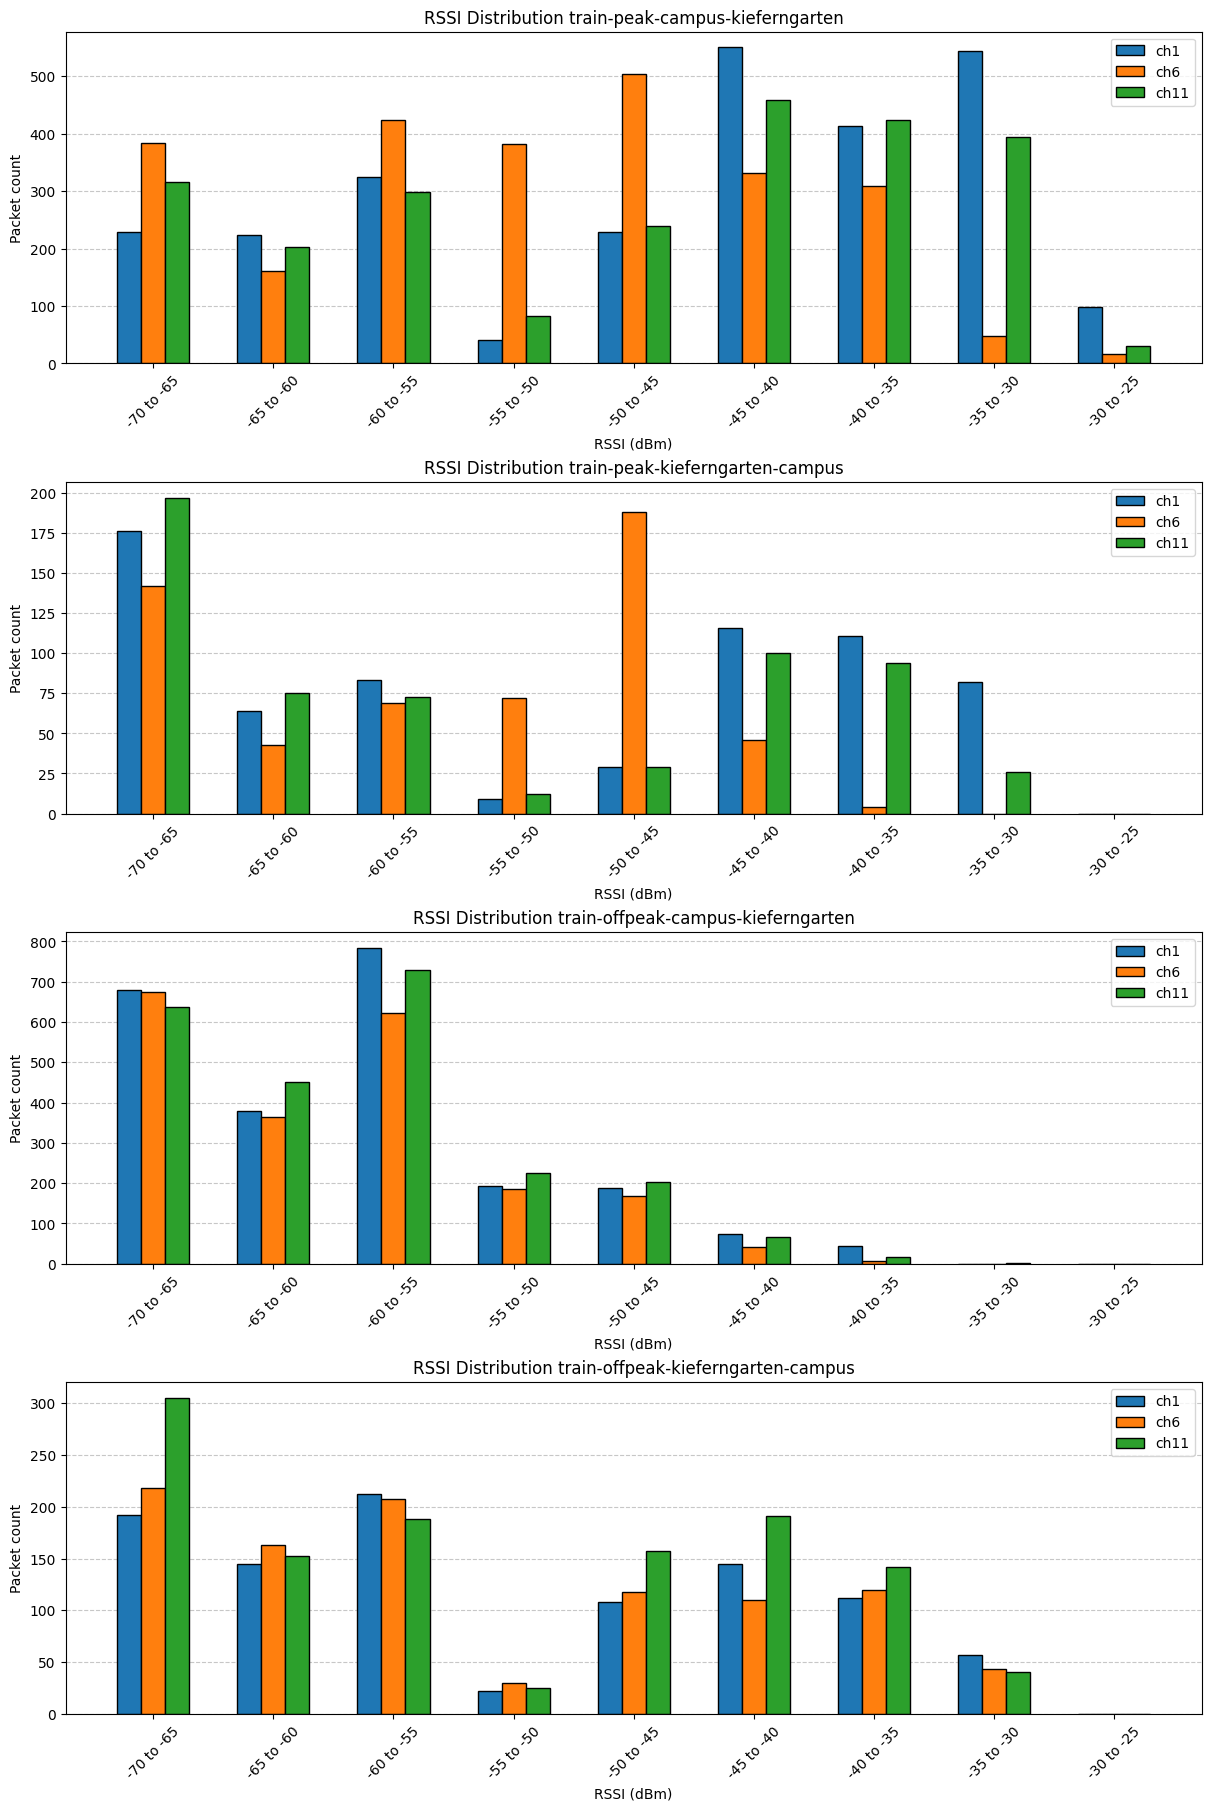

In [13]:
bins = np.arange(-70, -20, 5)
width = 1
bin_labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]
fig, axes = plt.subplots(4, 1, figsize=(12, 18), constrained_layout=True, sharex=False)
for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    for i, channel in enumerate(channels):
        rssi = [pkt["dBm_AntSignal"] for pkt in packets[scenario][channel]]
        hist, _ = np.histogram(rssi, bins=bins)
        ax.bar(bins[:-1] + (i-1)*width, hist, width=width, align='center', label=f'ch{channel}', edgecolor='black')
    ax.set_xlabel("RSSI (dBm)")
    ax.set_ylabel("Packet count")
    ax.set_title(f"RSSI Distribution {scenario}")
    ax.set_xticks(bins[:-1])
    ax.set_xticklabels(bin_labels, rotation=45)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("../report/images/part1/rssi/train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

### Strongest RSSI MAC Addresses

In [14]:
rssis_per_mac_per_channel = {scenario: {ch: {} for ch in channels} for scenario in scenarios}
for scenario in scenarios:
    for channel in channels:
        for packet in packets[scenario][channel]:
            src_mac = packet["src_mac"]
            if src_mac and packet["dBm_AntSignal"] is not None:
                if src_mac not in rssis_per_mac_per_channel[scenario][channel]:
                    rssis_per_mac_per_channel[scenario][channel][src_mac] = []
                rssis_per_mac_per_channel[scenario][channel][src_mac].append(packet["dBm_AntSignal"])

In [15]:
rssis_per_mac = {scenario: {} for scenario in scenarios}
for scenario in scenarios:
    for channel in channels:
        for mac, rssis in rssis_per_mac_per_channel[scenario][channel].items():
            if mac not in rssis_per_mac[scenario]:
                rssis_per_mac[scenario][mac] = []
            rssis_per_mac[scenario][mac].extend(rssis)

In [16]:
min_packet_count = 5
macs_with_geq_n_packets = {scenario: {} for scenario in scenarios}
for scenario in scenarios:
    for mac, rssis in rssis_per_mac[scenario].items():
        if len(rssis) >= min_packet_count:
            macs_with_geq_n_packets[scenario][mac] = rssis

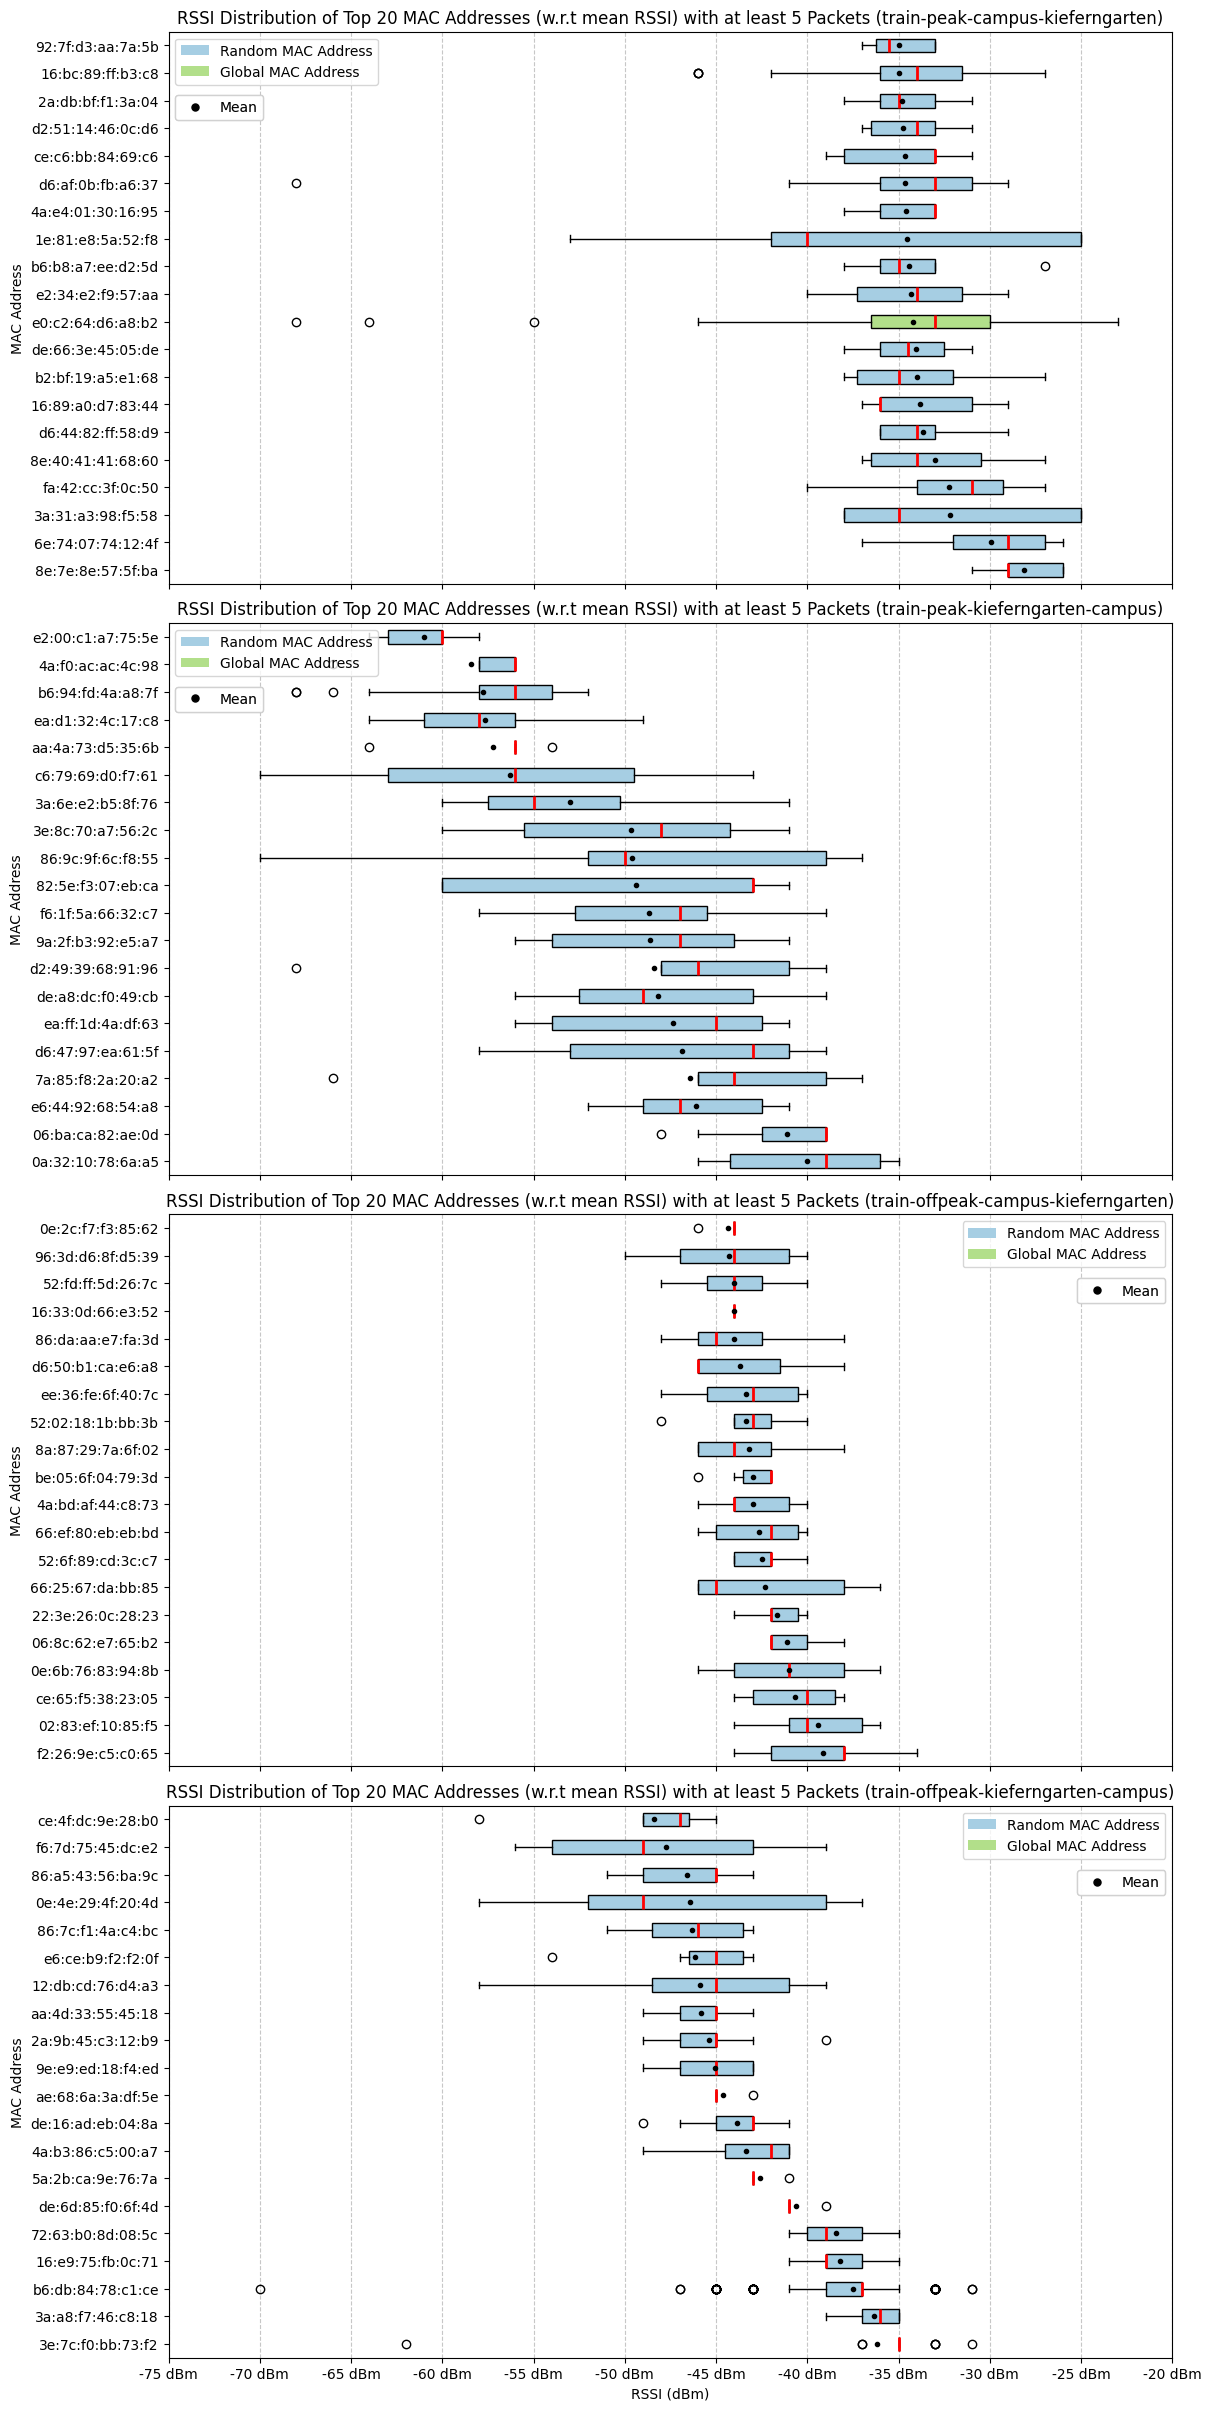

In [17]:
top_n = 20

fig, axes = plt.subplots(4, 1, figsize=(12, 24), constrained_layout=True, sharex=True)

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    sorted_macs = sorted(macs_with_geq_n_packets[scenario].items(), key=lambda x: np.mean(x[1]), reverse=True)[:top_n]
    box_data = [macs_with_geq_n_packets[scenario][mac] for mac, _ in sorted_macs]
    mac_labels = [mac for mac, _ in sorted_macs]
    mac_randomness = [util.is_random(mac) for mac in mac_labels]
    box_colors = []
    box_annotations = []
    for mac in mac_labels:
        if util.is_random(mac):
            box_colors.append(plt.cm.Paired.colors[0])
            box_annotations.append("")
        else:
            if mac not in known_macs.keys():
                box_colors.append(plt.cm.Paired.colors[2])
                box_annotations.append("")                
            else:
                print(f"Known MAC: {mac}")
                box_colors.append(plt.cm.Paired.colors[3])
                box_annotations.append(known_macs.get(mac))

    mac_type_handles = [
        Patch(facecolor=plt.cm.Paired.colors[0], label='Random MAC Address'),
        Patch(facecolor=plt.cm.Paired.colors[2], label='Global MAC Address'),
    ]

    if any(mac in known_macs.keys() for mac in mac_labels):
        mac_type_handles.append(Patch(facecolor=plt.cm.Paired.colors[3], label=f"Known MAC Address\n({', '.join(known_macs.values())})"))

    boxes = ax.boxplot(
        box_data,
        orientation='horizontal',
        patch_artist=True,
        tick_labels=mac_labels,
        showmeans=True,
        meanprops=dict(marker='.', markerfacecolor='black', markeredgecolor='black'),
        medianprops=dict(color='red', linewidth=2)
    )
    for patch, color in zip(boxes['boxes'], box_colors):
        patch.set_facecolor(color)

    legend_loc = 'upper left' if 'off' not in scenario else 'upper right'
    mac_type_legend = ax.legend(handles=mac_type_handles, loc=legend_loc)
    ax.add_artist(mac_type_legend)
    fig.canvas.draw()
    mac_type_legend_box = mac_type_legend.get_window_extent().transformed(ax.transAxes.inverted())
    mac_type_legend_y = mac_type_legend_box.y0

    mean_handles = [mlines.Line2D([0], [0], color='black', marker='.', linestyle='', markersize=10, label='Mean')]
    bbox_anchor_x = 0 if legend_loc == 'upper left' else 1
    mean_legend = ax.legend(handles=mean_handles, loc=legend_loc, bbox_to_anchor=(bbox_anchor_x, mac_type_legend_y - 0.01))
    ax.add_artist(mean_legend)

    ax.set_title(f"RSSI Distribution of Top {top_n} MAC Addresses (w.r.t mean RSSI) with at least {min_packet_count} Packets ({scenario})")
    ax.set_ylabel("MAC Address")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

axes[-1].set_xlabel("RSSI (dBm)")
all_x_lims = [ax.get_xlim() for ax in axes]
x_min_all = min(lim[0] for lim in all_x_lims)
x_max_all = max(lim[1] for lim in all_x_lims)
x_min = 5 * np.floor(x_min_all / 5)
x_max = 5 * np.ceil(x_max_all / 5)
axes[-1].set_xlim(x_min, x_max)
axes[-1].set_xticks(np.arange(x_min, x_max + 1, 5))
axes[-1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)} dBm"))

plt.savefig("../report/images/part1/rssi/top-macs-train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

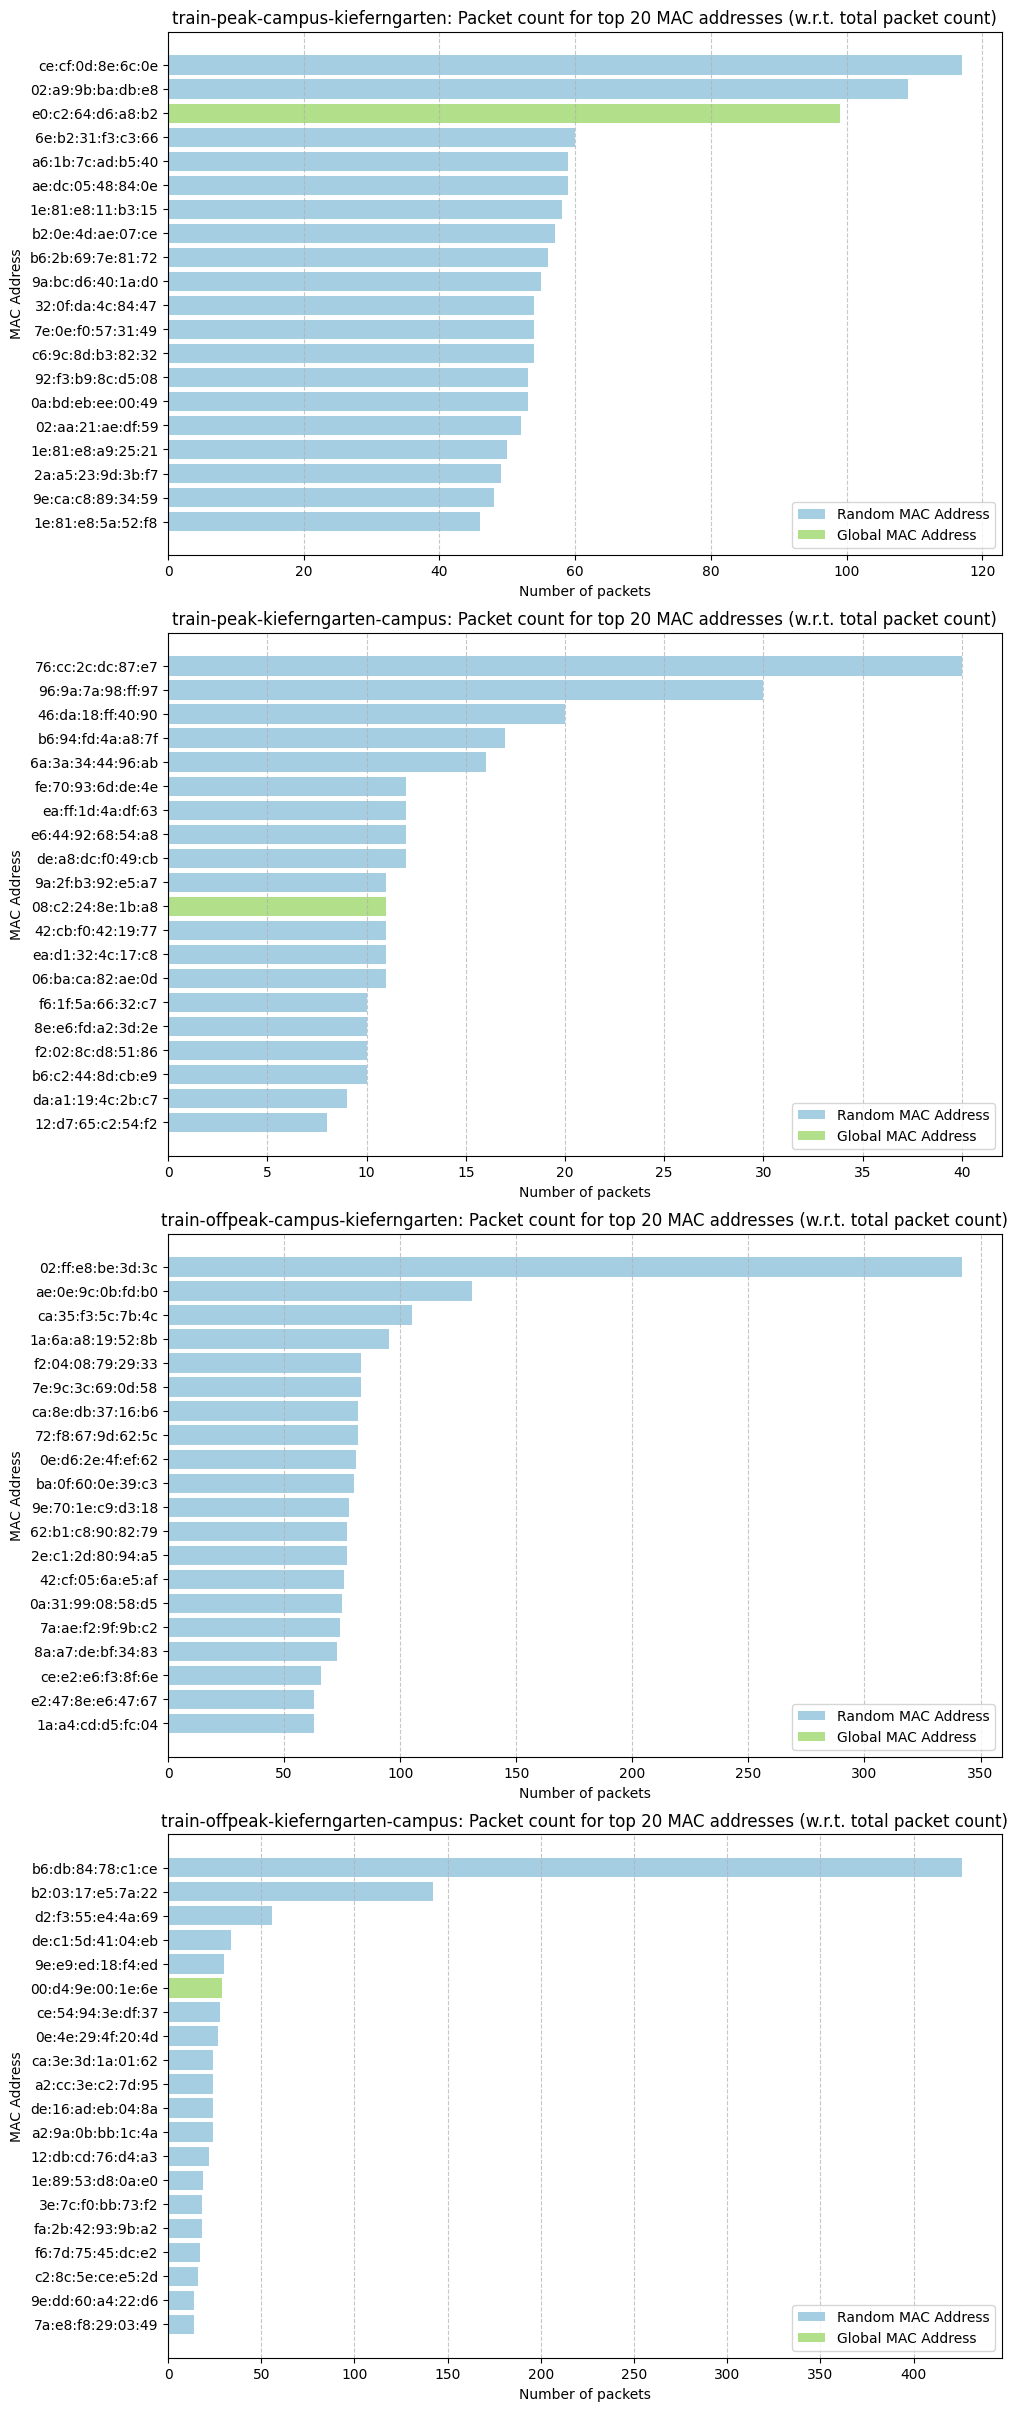

In [ ]:
top_n = 20

fig, axes = plt.subplots(4, 1, figsize=(10, 24), constrained_layout=True, sharex=False)

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    top_n_macs = sorted(macs_with_geq_n_packets[scenario].items(), key=lambda x: len(x[1]), reverse=True)[:top_n]
    total_counts = {mac: len(rssis) for mac, rssis in top_n_macs}

    bar_colors = []
    bar_annotations = []
    for mac in total_counts:
        if util.is_random(mac):
            bar_colors.append(plt.cm.Paired.colors[0])
            bar_annotations.append("")
        else:
            if mac not in known_macs.keys():
                bar_colors.append(plt.cm.Paired.colors[2])
                bar_annotations.append("")
            else:
                bar_colors.append(plt.cm.Paired.colors[3])
                bar_annotations.append(known_macs.get(mac))

    sorted_total = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)
    mac_labels = [mac for mac, _ in sorted_total]
    counts = [count for _, count in sorted_total]
    
    color_map = {mac: color for mac, color in zip(total_counts.keys(), bar_colors)}
    annotation_map = {mac: ann for mac, ann in zip(total_counts.keys(), bar_annotations)}
    
    sorted_colors = [color_map[mac] for mac in mac_labels]
    sorted_annotations = [annotation_map[mac] for mac in mac_labels]

    bars = ax.barh(
        mac_labels,
        counts,
        color=sorted_colors
    )

    for bar, ann in zip(bars, sorted_annotations):
        if ann:
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, ann, va='center', ha='left', fontsize=10)

    mac_type_handles = [
        Patch(facecolor=plt.cm.Paired.colors[0], label="Random MAC Address"),
        Patch(facecolor=plt.cm.Paired.colors[2], label="Global MAC Address")
    ]
    if any(mac in known_macs.keys() for mac in total_counts):
        mac_type_handles.append(Patch(facecolor=plt.cm.Paired.colors[3], label=f"Known MAC Address\n({', '.join(known_macs.values())})"))

    ax.legend(handles=mac_type_handles, loc='lower right')
    
    ax.set_xlabel("Number of packets")
    ax.set_ylabel("MAC Address")
    ax.set_title(f"{scenario}: Packet count for top {top_n} MAC addresses (w.r.t. total packet count)")
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.invert_yaxis()

plt.savefig("../report/images/part1/packet-counts/top-macs-train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
known_mac_packet_counts = {scenario: {mac: 0 for mac in known_macs.keys()} for scenario in scenarios}
for scenario in scenarios:
    for channel in channels:
        for packet in packets[scenario][channel]:
            src_mac = packet["src_mac"]
            if src_mac in known_macs.keys():
                known_mac_packet_counts[scenario][src_mac] += 1

print("\\begin{table}[ht]")
print("    \\centering")
print("    \\resizebox{\\columnwidth}{!}{")
header = " & ".join([f"\\textbf{{{name}}}" for name in known_macs.values()])
print(f"    \\begin{{tabular}}{{|l|{'c' * len(known_macs)}|}}")
print("        \\hline")
print(f"        \\textbf{{Scenario}} & {header} \\\\")
print("        \\hline")

for scenario, counts in known_mac_packet_counts.items():
    row = [scenario] + [str(counts[mac]) for mac in known_macs.keys()]
    print("        " + " & ".join(row) + " \\\\")
    print("        \\hline")

print("    \\end{tabular}")
print("    }")
print("    \\caption{Packet counts of known devices in train scenarios.}")
print("    \\label{tab:known_devices_train}")
print("\\end{table}")

\begin{table}[ht]
    \centering
    \resizebox{\columnwidth}{!}{
    \begin{tabular}{|l|ccc|}
        \hline
        \textbf{Scenario} & \textbf{Controller Laptop} & \textbf{Smartphone} & \textbf{Raspberry Pi} \\
        \hline
        train-peak-campus-kieferngarten & 1 & 0 & 0 \\
        \hline
        train-peak-kieferngarten-campus & 3 & 0 & 0 \\
        \hline
        train-offpeak-campus-kieferngarten & 3 & 0 & 0 \\
        \hline
        train-offpeak-kieferngarten-campus & 2 & 0 & 0 \\
        \hline
    \end{tabular}
    }
    \caption{Packet counts of known devices in train scenarios.}
    \label{tab:known_devices_train}
\end{table}


In [20]:
for scenario in scenarios:
    phone_mac = [mac for mac in known_macs.keys() if "Controller Laptop" in known_macs[mac]][0]
    if phone_mac in rssis_per_mac[scenario]:
        rssi_values = rssis_per_mac[scenario][phone_mac]
        if rssi_values:
            mean_rssi = np.mean(rssi_values)
            print(f"Mean RSSI for {phone_mac} in {scenario}: {mean_rssi:.2f} dBm")
        else:
            print(f"No RSSI values found for {phone_mac} in {scenario}.")
    else:
        print(f"{phone_mac} not found in {scenario}.")

Mean RSSI for 28:df:eb:53:a0:25 in train-peak-campus-kieferngarten: -49.00 dBm
Mean RSSI for 28:df:eb:53:a0:25 in train-peak-kieferngarten-campus: -42.00 dBm
Mean RSSI for 28:df:eb:53:a0:25 in train-offpeak-campus-kieferngarten: -42.00 dBm
Mean RSSI for 28:df:eb:53:a0:25 in train-offpeak-kieferngarten-campus: -42.00 dBm


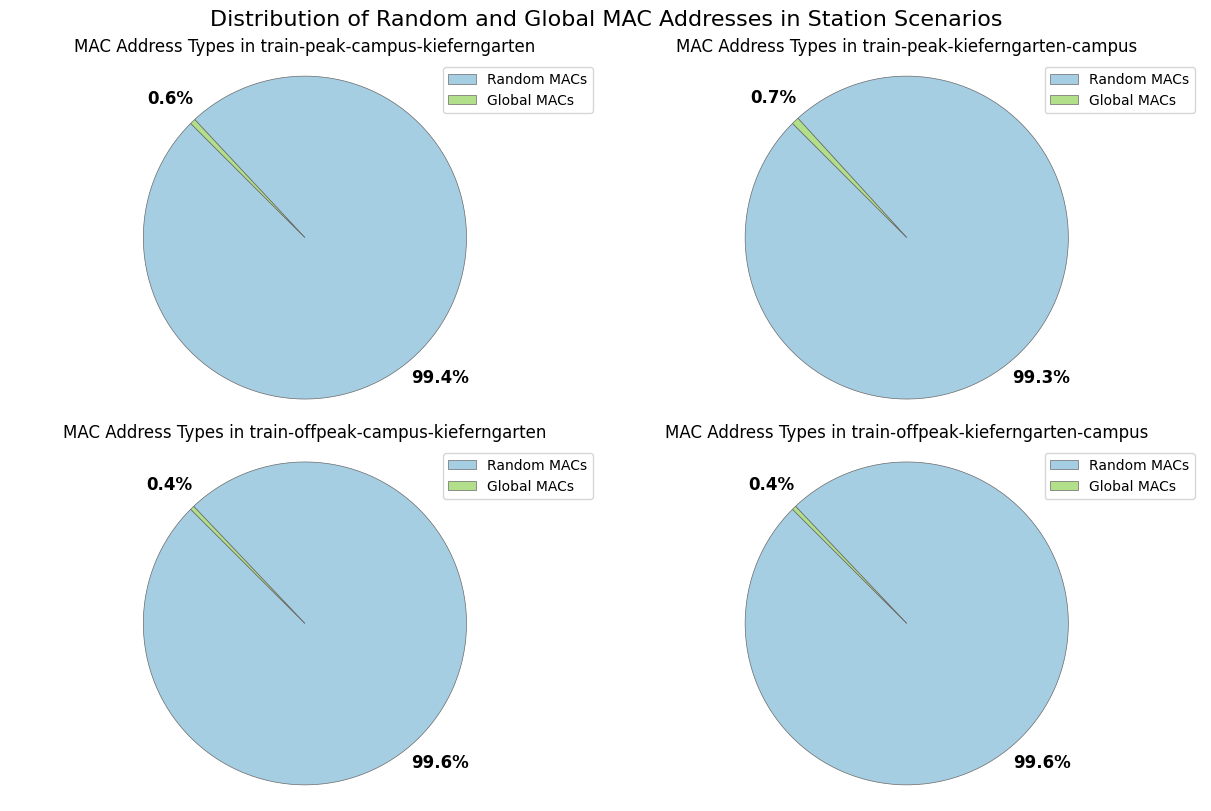

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    random_macs = get_mac_stats(packets, scenario)["random_macs"]
    global_macs = get_mac_stats(packets, scenario)["global_macs"]
    values = [random_macs, global_macs]
    labels_list = ["Random MACs", "Global MACs"]
    colors = [plt.cm.Paired.colors[0], plt.cm.Paired.colors[2]]

    wedges, _ = ax.pie(
        values,
        labels=None,
        startangle=135,
        colors=colors,
        wedgeprops=dict(edgecolor='dimgray', linewidth=0.5)
    )
    ax.legend(wedges, labels_list, loc="upper right", fontsize=10)
    ax.set_title(f"MAC Address Types in {scenario}")
    ax.axis('equal')

    total = sum(values)
    for i, w in enumerate(wedges):
        angle = (w.theta1 + w.theta2) / 2
        x = 1.2 * np.cos(np.deg2rad(angle))
        y = 1.2 * np.sin(np.deg2rad(angle))
        percent = values[i] / total * 100
        ax.text(x, y, f"{percent:.1f}%", ha='center', va='center', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Random and Global MAC Addresses in Station Scenarios", fontsize=16)
plt.savefig("../report/images/part1/mac-address-types/train-scenarios.png", dpi=300, bbox_inches='tight')

plt.show()

In [23]:
print("\\begin{table}[ht]")
print("    \\centering")
print("    \\caption{MAC Address Randomization Ratios in Train Scenarios}")
print("    \\label{tab:mac_randomization_train}")
print("    \\resizebox{\\columnwidth}{!}{")
print("    \\begin{tabular}{|l|r|r|r|r|}")
print("        \\hline")
print("        \\textbf{Scenario} & \\textbf{Random} & \\textbf{Global} & \\textbf{Total} & \\textbf{Random Ratio (\\%)} \\\\")
print("        \\hline")

for scenario in scenarios:
    mac_stats = get_mac_stats(packets, scenario)
    random_macs = mac_stats['random_macs']
    global_macs = mac_stats['global_macs']
    total_macs = random_macs + global_macs
    random_ratio = (random_macs / total_macs) * 100 if total_macs > 0 else 0
    
    scenario_latex = scenario.replace('_', '\\_')

    print(f"        {scenario_latex} & {random_macs} & {global_macs} & {total_macs} & {random_ratio:.2f}\\% \\\\")

print("        \\hline")
print("    \\end{tabular}")
print("    }")
print("\\end{table}")

\begin{table}[ht]
    \centering
    \caption{MAC Address Randomization Ratios in Train Scenarios}
    \label{tab:mac_randomization_train}
    \resizebox{\columnwidth}{!}{
    \begin{tabular}{|l|r|r|r|r|}
        \hline
        \textbf{Scenario} & \textbf{Random} & \textbf{Global} & \textbf{Total} & \textbf{Random Ratio (\%)} \\
        \hline
        train-peak-campus-kieferngarten & 1976 & 11 & 1987 & 99.45\% \\
        train-peak-kieferngarten-campus & 673 & 5 & 678 & 99.26\% \\
        train-offpeak-campus-kieferngarten & 723 & 3 & 726 & 99.59\% \\
        train-offpeak-kieferngarten-campus & 1189 & 5 & 1194 & 99.58\% \\
        \hline
    \end{tabular}
    }
\end{table}


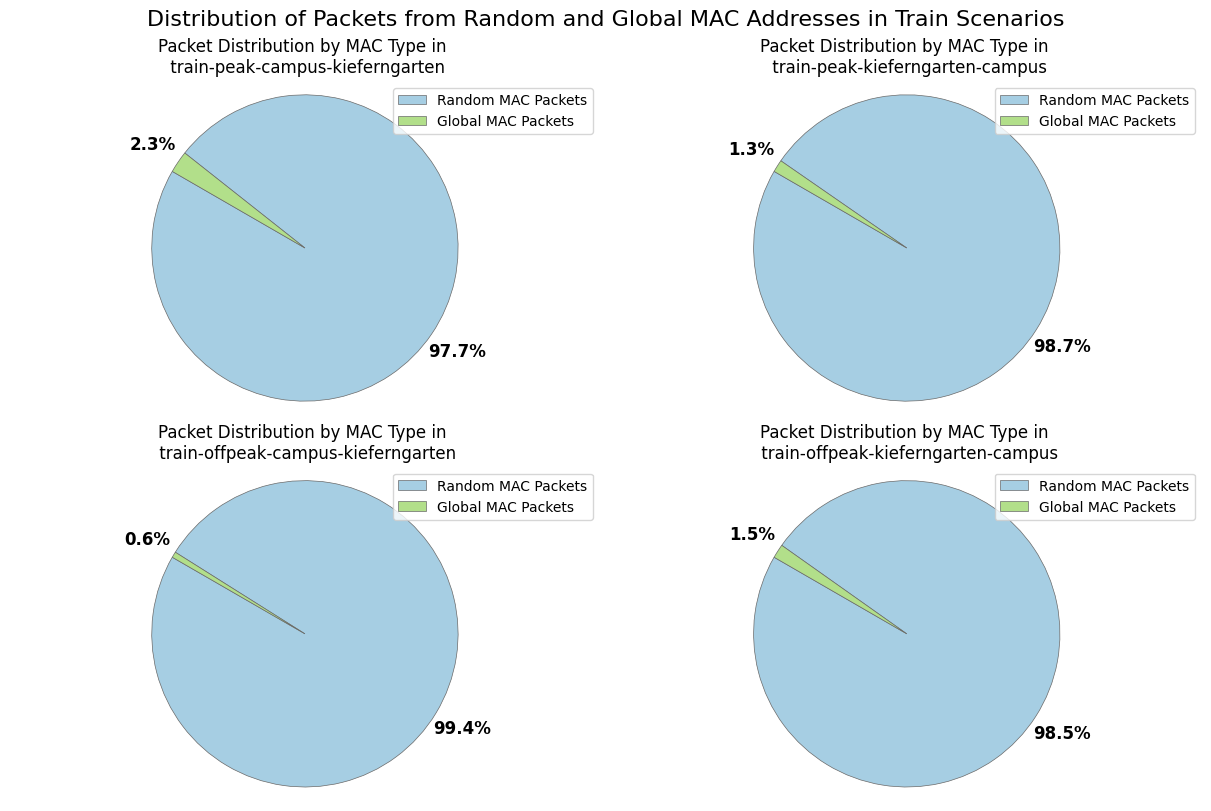

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    random_mac_packets = 0
    global_mac_packets = 0
    for channel in channels:
        for packet in packets[scenario][channel]:
            src_mac = packet["src_mac"]
            if src_mac:
                if util.is_random(src_mac):
                    random_mac_packets += 1
                else:
                    global_mac_packets += 1
    values = [random_mac_packets, global_mac_packets]
    labels_list = ["Random MAC Packets", "Global MAC Packets"]
    colors = [plt.cm.Paired.colors[0], plt.cm.Paired.colors[2]]
    
    wedges, _ = ax.pie(
        values,
        labels=None,
        startangle=150,
        colors=colors,
        wedgeprops=dict(edgecolor='dimgray', linewidth=0.5)
    )
    ax.legend(wedges, labels_list, loc="upper right", fontsize=10)
    ax.set_title(f"Packet Distribution by MAC Type in \n {scenario}")
    ax.axis('equal')
    total = sum(values)
    for i, w in enumerate(wedges):
        angle = (w.theta1 + w.theta2) / 2
        x = 1.2 * np.cos(np.deg2rad(angle))
        y = 1.2 * np.sin(np.deg2rad(angle))
        percent = values[i] / total * 100
        ax.text(x, y, f"{percent:.1f}%", ha='center', va='center', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Packets from Random and Global MAC Addresses in Train Scenarios", fontsize=16)
plt.savefig("../report/images/part1/mac-address-types/train-scenarios-packet-based.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
print("\\begin{table}[ht]")
print("    \\centering")
print("    \\caption{Packet-based MAC Address Randomization Ratios in Train Scenarios}")
print("    \\label{tab:mac_randomization_train_packets}")
print("    \\resizebox{\\columnwidth}{!}{")
print("    \\begin{tabular}{|l|r|r|r|r|}")
print("        \\hline")
print("        \\textbf{Scenario} & \\textbf{Random MAC Pkts} & \\textbf{Global MAC Pkts} & \\textbf{Total Pkts} & \\textbf{Random Pkts Ratio (\\%)} \\\\")
print("        \\hline")

for scenario in scenarios:
    random_mac_packets = 0
    global_mac_packets = 0
    for channel in channels:
        for packet in packets[scenario][channel]:
            src_mac = packet["src_mac"]
            if src_mac:
                if util.is_random(src_mac):
                    random_mac_packets += 1
                else:
                    global_mac_packets += 1
    
    total_packets = random_mac_packets + global_mac_packets
    random_ratio = (random_mac_packets / total_packets) * 100 if total_packets > 0 else 0
    
    scenario_latex = scenario.replace('_', '\\_')

    print(f"        {scenario_latex} & {random_mac_packets} & {global_mac_packets} & {total_packets} & {random_ratio:.2f}\\% \\\\")

print("        \\hline")
print("    \\end{tabular}")
print("    }")
print("\\end{table}")

\begin{table}[ht]
    \centering
    \caption{Packet-based MAC Address Randomization Ratios in Train Scenarios}
    \label{tab:mac_randomization_train_packets}
    \resizebox{\columnwidth}{!}{
    \begin{tabular}{|l|r|r|r|r|}
        \hline
        \textbf{Scenario} & \textbf{Random MAC Pkts} & \textbf{Global MAC Pkts} & \textbf{Total Pkts} & \textbf{Random Pkts Ratio (\%)} \\
        \hline
        train-peak-campus-kieferngarten & 7477 & 177 & 7654 & 97.69\% \\
        train-peak-kieferngarten-campus & 1816 & 24 & 1840 & 98.70\% \\
        train-offpeak-campus-kieferngarten & 6696 & 41 & 6737 & 99.39\% \\
        train-offpeak-kieferngarten-campus & 3155 & 47 & 3202 & 98.53\% \\
        \hline
    \end{tabular}
    }
\end{table}


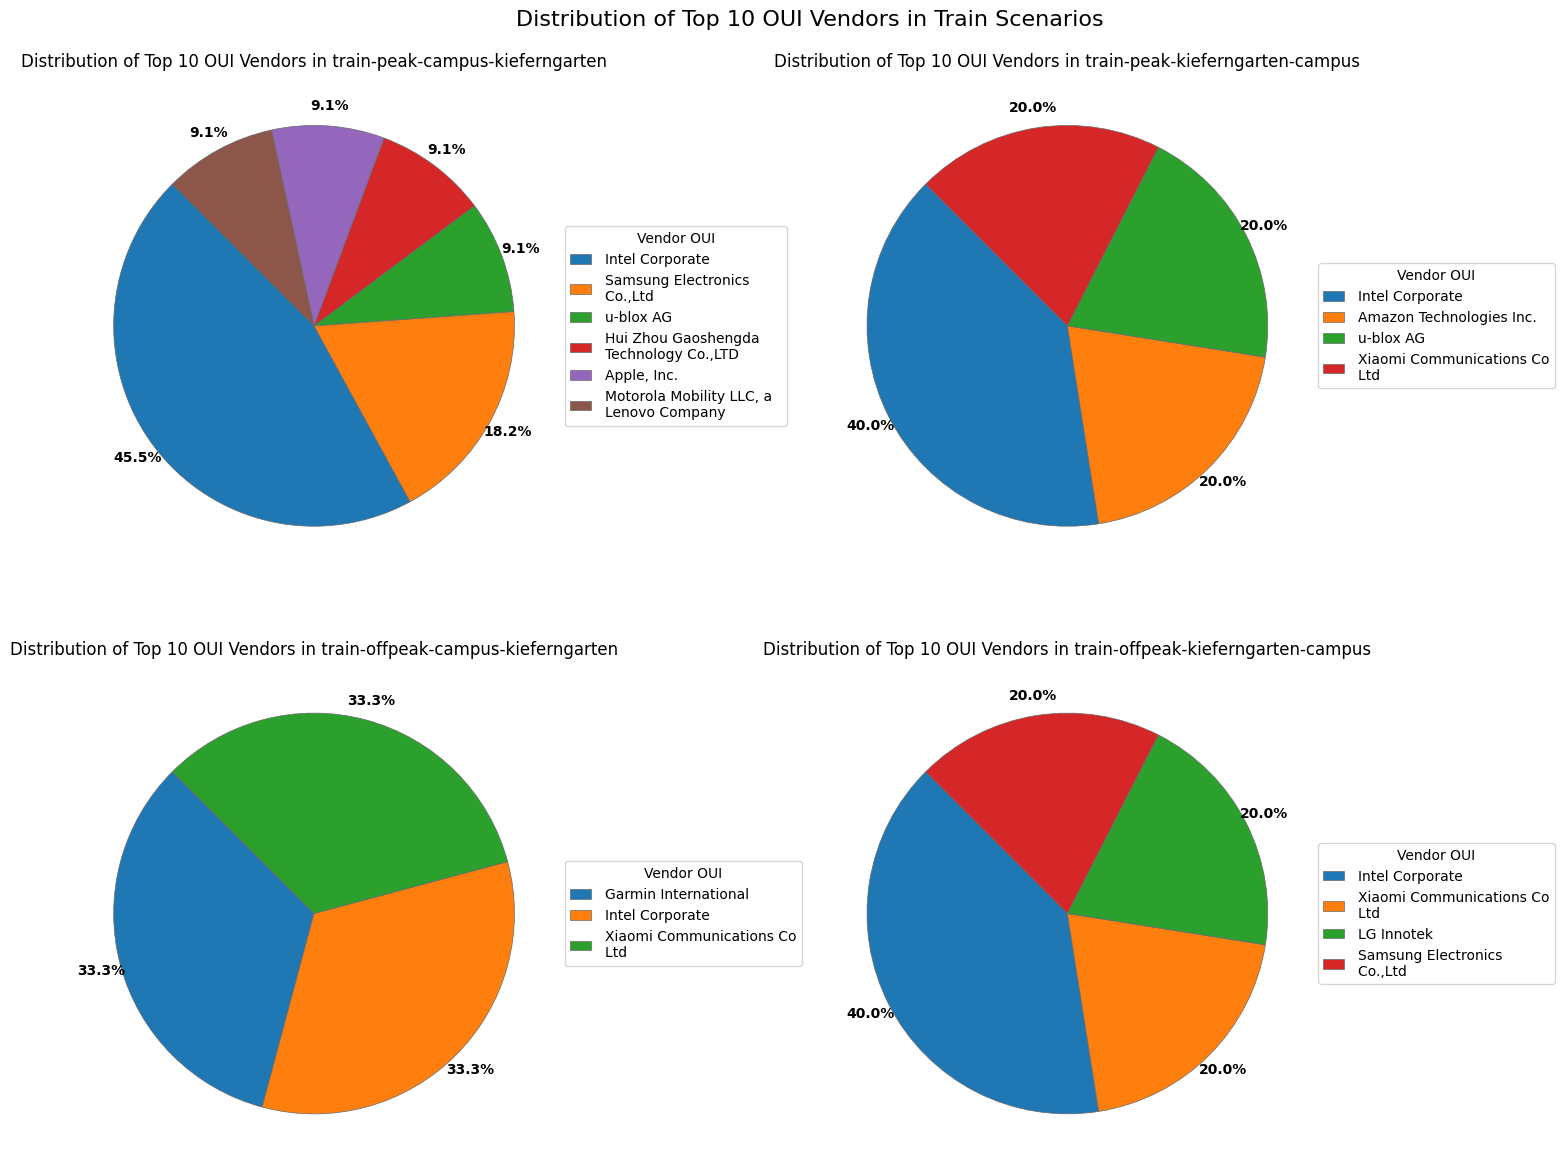

In [40]:
top_n = 10

fig, axes = plt.subplots(2, 2, figsize=(15, 12), constrained_layout=True)
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    unique_macs = set()
    for channel in channels:
        for packet in packets[scenario][channel]:
            if packet["src_mac"]:
                unique_macs.add(packet["src_mac"])

    oui_counts = {}
    for mac in unique_macs:
        oui = util.eval_oui(mac, parser.PcapParser.OUI_DICT)
        if oui and oui != "Unknown":
            oui_counts[oui] = oui_counts.get(oui, 0) + 1

    sorted_oui_counts = sorted(oui_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not sorted_oui_counts:
        ax.text(0.5, 0.5, f"No OUI data available for\n{scenario}", ha='center', va='center', fontsize=12)
        ax.set_title(f"Top {top_n} OUI Vendors in {scenario}")
        ax.axis('off')
        continue

    vendor_labels, sizes = zip(*sorted_oui_counts)
    colors = cm.tab10.colors[:len(vendor_labels)]

    wedges, _ = ax.pie(
        sizes,
        labels=None,
        startangle=135,
        colors=colors,
        wedgeprops=dict(edgecolor='dimgray', linewidth=0.5)
    )
    
    max_label_len = 24
    def wrap_label(label, width):
        words = label.split()
        lines = []
        current = ""
        for word in words:
            if len(current) + len(word) + (1 if current else 0) <= width:
                current += (" " if current else "") + word
            else:
                lines.append(current.ljust(width))
                current = word
        if current:
            lines.append(current.ljust(width))
        return "\n".join(lines)
    vendor_labels_wrapped = [wrap_label(label, max_label_len) for label in vendor_labels]
    
    legend = ax.legend(
        wedges,
        vendor_labels_wrapped,
        title="Vendor OUI",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=True,
        borderaxespad=0,
        handlelength=1.5,
        handletextpad=1,
    )

    total = sum(sizes)
    for i, w in enumerate(wedges):
        percent = sizes[i] / total * 100
        if percent >= 1:
            angle = (w.theta1 + w.theta2) / 2
            x = 1.1 * np.cos(np.deg2rad(angle))
            y = 1.1 * np.sin(np.deg2rad(angle))
            ax.text(x, y, f"{percent:.1f}%", ha='center', va='center', fontsize=10, fontweight='bold', color='black')

    ax.set_title(f"Distribution of Top {top_n} OUI Vendors in {scenario}")

plt.suptitle(f"Distribution of Top {top_n} OUI Vendors in Train Scenarios", fontsize=16)
plt.savefig(f"../report/images/part1/oui-vendors/train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

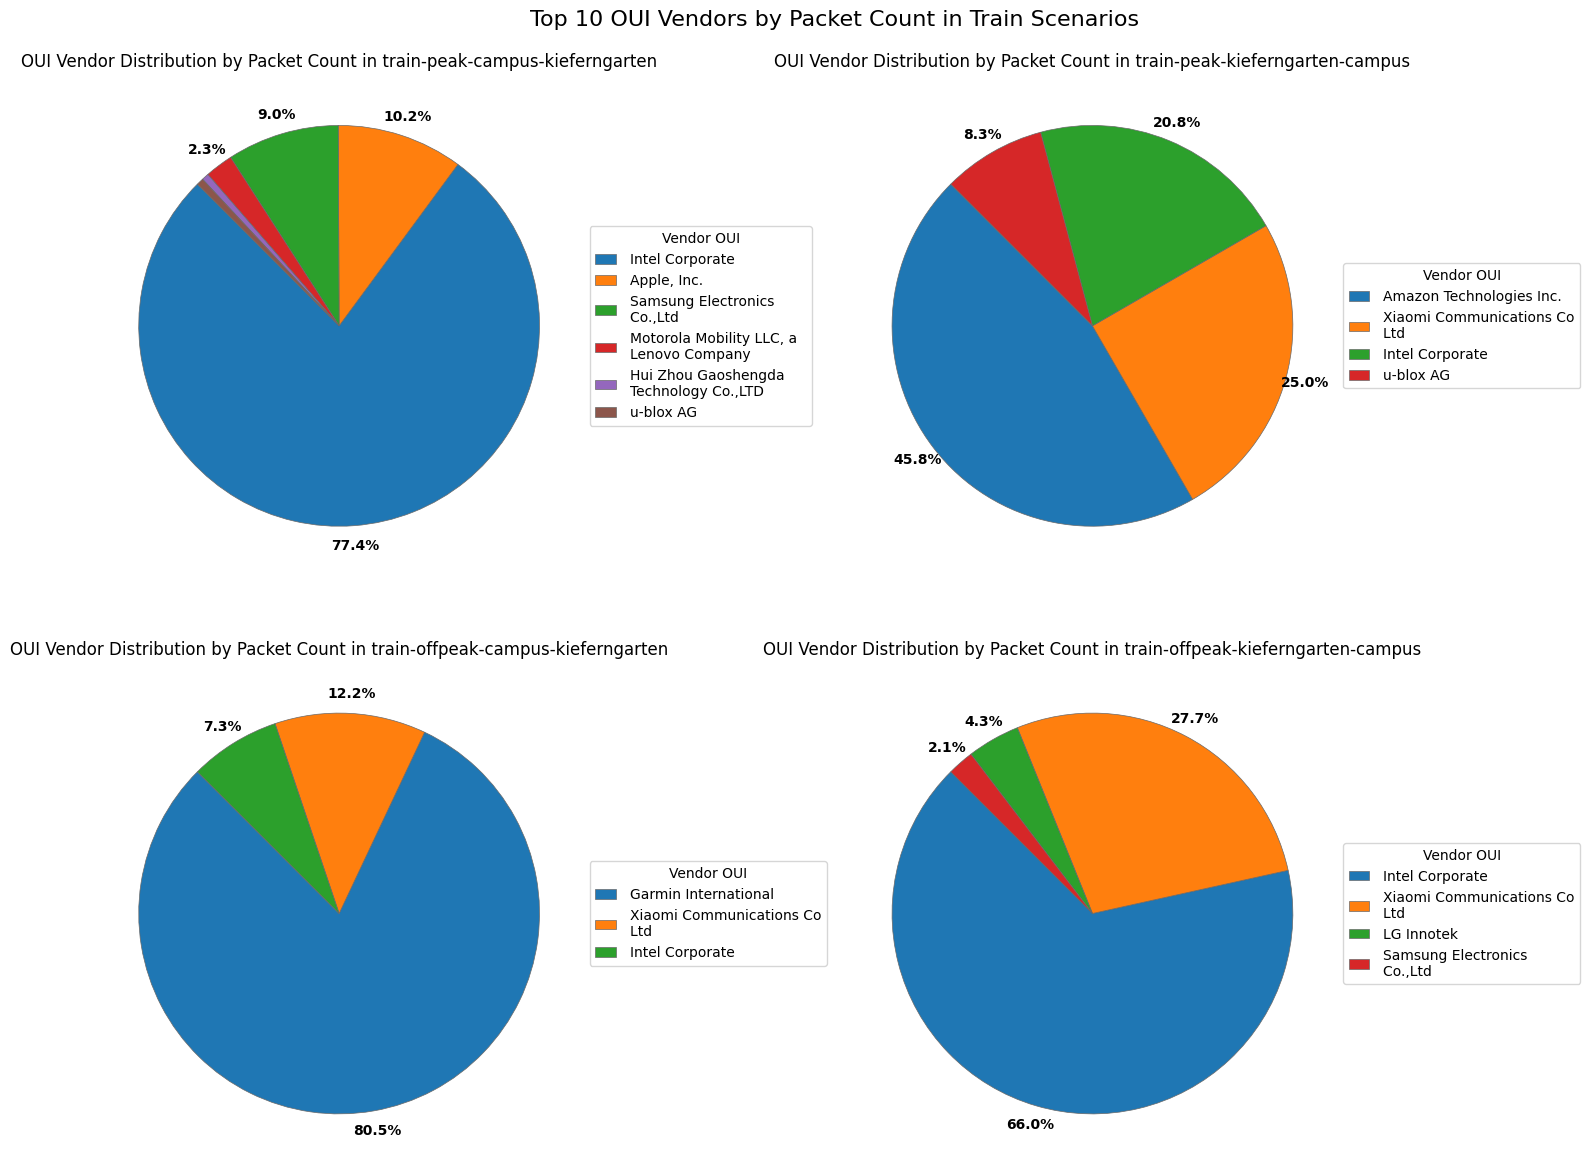

In [41]:

top_n = 10

fig, axes = plt.subplots(2, 2, figsize=(15, 12), constrained_layout=True)
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    oui_counts = {}
    for channel in channels:
        for packet in packets[scenario][channel]:
            src_mac = packet["src_mac"]
            if src_mac:
                oui = util.eval_oui(src_mac, parser.PcapParser.OUI_DICT)
                if oui and oui != "Unknown":
                    oui_counts[oui] = oui_counts.get(oui, 0) + 1

    sorted_oui_counts = sorted(oui_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not sorted_oui_counts:
        ax.text(0.5, 0.5, f"No OUI data available for\n{scenario}", ha='center', va='center', fontsize=12)
        ax.set_title(f"Top {top_n} OUI Vendors in {scenario}")
        ax.axis('off')
        continue

    vendor_labels, sizes = zip(*sorted_oui_counts)
    colors = cm.tab10.colors[:len(vendor_labels)]

    wedges, _ = ax.pie(
        sizes,
        labels=None,
        startangle=135,
        colors=colors,
        wedgeprops=dict(edgecolor='dimgray', linewidth=0.5)
    )
    
    max_label_len = 24
    def wrap_label(label, width):
        words = label.split()
        lines = []
        current = ""
        for word in words:
            if len(current) + len(word) + (1 if current else 0) <= width:
                current += (" " if current else "") + word
            else:
                lines.append(current.ljust(width))
                current = word
        if current:
            lines.append(current.ljust(width))
        return "\n".join(lines)
    vendor_labels_wrapped = [wrap_label(label, max_label_len) for label in vendor_labels]
    
    legend = ax.legend(
        wedges,
        vendor_labels_wrapped,
        title="Vendor OUI",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=True,
        borderaxespad=0,
        handlelength=1.5,
        handletextpad=1,
    )

    total = sum(sizes)
    for i, w in enumerate(wedges):
        percent = sizes[i] / total * 100
        if percent >= 1:
            angle = (w.theta1 + w.theta2) / 2
            x = 1.1 * np.cos(np.deg2rad(angle))
            y = 1.1 * np.sin(np.deg2rad(angle))
            ax.text(x, y, f"{percent:.1f}%", ha='center', va='center', fontsize=10, fontweight='bold', color='black')

    ax.set_title(f"OUI Vendor Distribution by Packet Count in {scenario}")

plt.suptitle(f"Top {top_n} OUI Vendors by Packet Count in Train Scenarios", fontsize=16)
plt.savefig(f"../report/images/part1/oui-vendors/train-scenarios-packet-count.png", dpi=300, bbox_inches='tight')
plt.show()

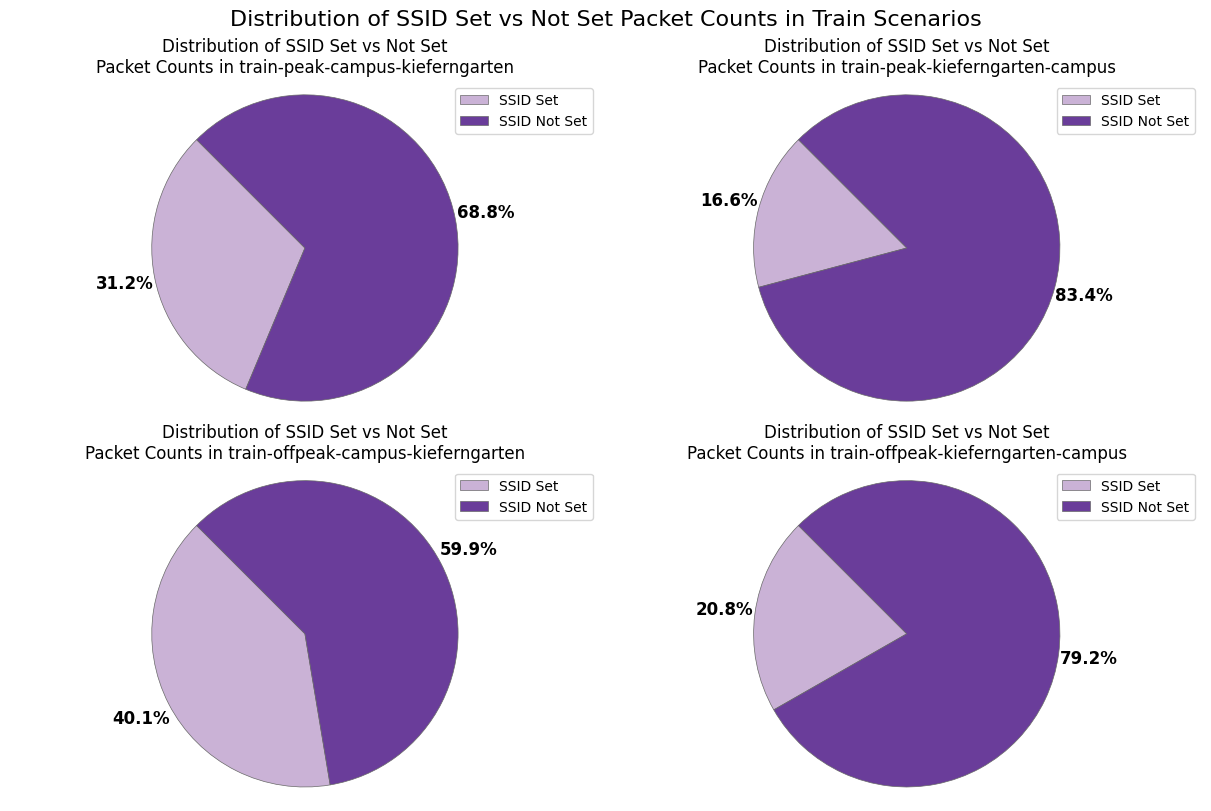

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    ssid_set_count = get_ssid_stats(packets, scenario)
    total_packets = get_packet_count_stats(packets, scenario)
    ssid_not_set_count = total_packets - ssid_set_count
    values = [ssid_set_count, ssid_not_set_count]
    labels_list = ["SSID Set", "SSID Not Set"]
    colors = [plt.cm.Paired.colors[8], plt.cm.Paired.colors[9]]

    wedges, _ = ax.pie(
        values,
        labels=None,
        startangle=135,
        colors=colors,
        wedgeprops=dict(edgecolor='dimgray', linewidth=0.5)
    )
    ax.legend(wedges, labels_list, loc="upper right", fontsize=10)
    ax.set_title(f"Distribution of SSID Set vs Not Set\nPacket Counts in {scenario}")
    ax.axis('equal')

    total = sum(values)
    if total > 0:
        for i, w in enumerate(wedges):
            angle = (w.theta1 + w.theta2) / 2
            x = 1.2 * np.cos(np.deg2rad(angle))
            y = 1.2 * np.sin(np.deg2rad(angle))
            percent = values[i] / total * 100
            ax.text(x, y, f"{percent:.1f}%", ha='center', va='center', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of SSID Set vs Not Set Packet Counts in Train Scenarios", fontsize=16)
plt.savefig("../report/images/part1/ssid/train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

In [43]:
print("\\begin{table}[ht]")
print("    \\centering")
print("    \\caption{Packet Distribution by SSID Presence in Train Scenarios}")
print("    \\label{tab:ssid_presence_train}")
print("    \\resizebox{\\columnwidth}{!}{")
print("    \\begin{tabular}{|l|r|r|r|r|}")
print("        \\hline")
print("        \\textbf{Scenario} & \\textbf{SSID Set} & \\textbf{SSID Not Set} & \\textbf{Total Packets} & \\textbf{SSID Set Ratio (\\%)} \\\\")
print("        \\hline")

for scenario in scenarios:
    ssid_set_count = get_ssid_stats(packets, scenario)
    total_packets = get_packet_count_stats(packets, scenario)
    ssid_not_set_count = total_packets - ssid_set_count
    ratio = (ssid_set_count / total_packets) * 100 if total_packets > 0 else 0
    
    scenario_latex = scenario.replace('_', '\\_')

    print(f"        {scenario_latex} & {ssid_set_count} & {ssid_not_set_count} & {total_packets} & {ratio:.2f}\\% \\\\")

print("        \\hline")
print("    \\end{tabular}")
print("    }")
print("\\end{table}")

\begin{table}[ht]
    \centering
    \caption{Packet Distribution by SSID Presence in Train Scenarios}
    \label{tab:ssid_presence_train}
    \resizebox{\columnwidth}{!}{
    \begin{tabular}{|l|r|r|r|r|}
        \hline
        \textbf{Scenario} & \textbf{SSID Set} & \textbf{SSID Not Set} & \textbf{Total Packets} & \textbf{SSID Set Ratio (\%)} \\
        \hline
        train-peak-campus-kieferngarten & 2387 & 5267 & 7654 & 31.19\% \\
        train-peak-kieferngarten-campus & 306 & 1534 & 1840 & 16.63\% \\
        train-offpeak-campus-kieferngarten & 2704 & 4033 & 6737 & 40.14\% \\
        train-offpeak-kieferngarten-campus & 665 & 2537 & 3202 & 20.77\% \\
        \hline
    \end{tabular}
    }
\end{table}


/tmp/ipykernel_89960/1342071248.py:48: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../report/images/part1/ssid/top-ssids-train-scenarios.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_89960/1342071248.py:48: UserWarning: Glyph 27849 (\N{CJK UNIFIED IDEOGRAPH-6CC9}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../report/images/part1/ssid/top-ssids-train-scenarios.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_89960/1342071248.py:48: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../report/images/part1/ssid/top-ssids-train-scenarios.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_89960/1342071248.py:48: UserWarning: Glyph 39302 (\N{CJK UNIFIED IDEOGRAPH-9986}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../report/images/part1/ssid/top-ssids-train-scenarios.png", dpi=300, bbox_inches='tight')
/home/erdem/miniconda3/envs/cmb/lib/python3.13/site-

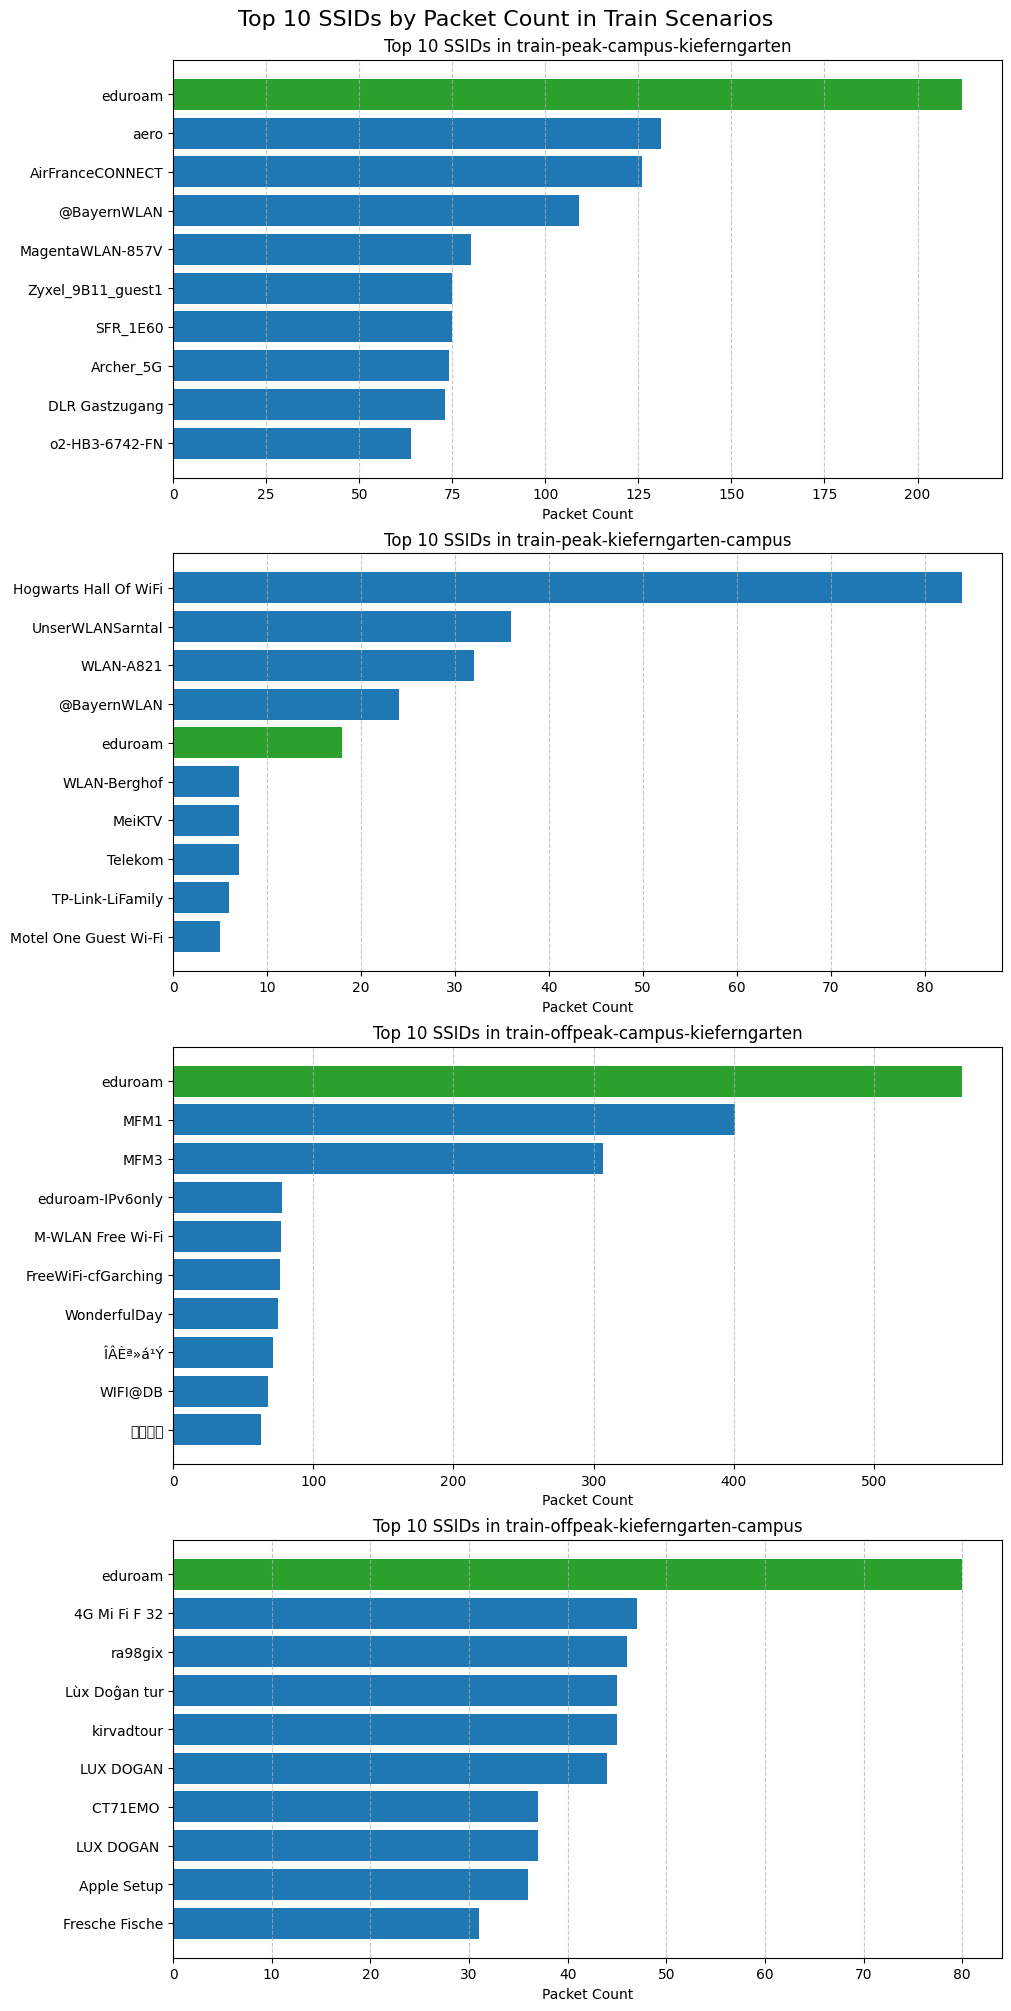

In [44]:
top_n = 10
fig, axes = plt.subplots(4, 1, figsize=(10, 20), constrained_layout=True)
axes = axes.flatten()

special_ssids = {
    "eduroam": plt.cm.Paired.colors[3],
    "nacar": plt.cm.Paired.colors[1]
}
default_color = plt.cm.Paired.colors[7]

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    ssid_counts = {}
    for channel in channels:
        for packet in packets[scenario][channel]:
            ssid = packet["SSID"]
            if ssid is not None:
                try:
                    ssid = ssid.decode("utf-8")
                except UnicodeDecodeError:
                    ssid = ssid.decode("latin1")
                if ssid != "":
                    ssid_counts[ssid] = ssid_counts.get(ssid, 0) + 1

    sorted_ssids = sorted(ssid_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    if not sorted_ssids:
        ax.text(0.5, 0.5, f"No SSID data available for\n{scenario}", ha='center', va='center')
        ax.set_title(f"Top {top_n} SSIDs in {scenario}")
        ax.axis('off')
        continue

    ssid_labels, sizes = zip(*sorted_ssids)
    
    special_ssids = {
        "eduroam": "tab:green",
        "nacar": "tab:orange"
    }
    default_color = "tab:blue"
    colors = [special_ssids.get(label, default_color) for label in ssid_labels]

    ax.barh(ssid_labels, sizes, color=colors)
    ax.set_xlabel("Packet Count")
    ax.set_title(f"Top {top_n} SSIDs in {scenario}")
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle(f"Top {top_n} SSIDs by Packet Count in Train Scenarios", fontsize=16)
plt.savefig(f"../report/images/part1/ssid/top-ssids-train-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

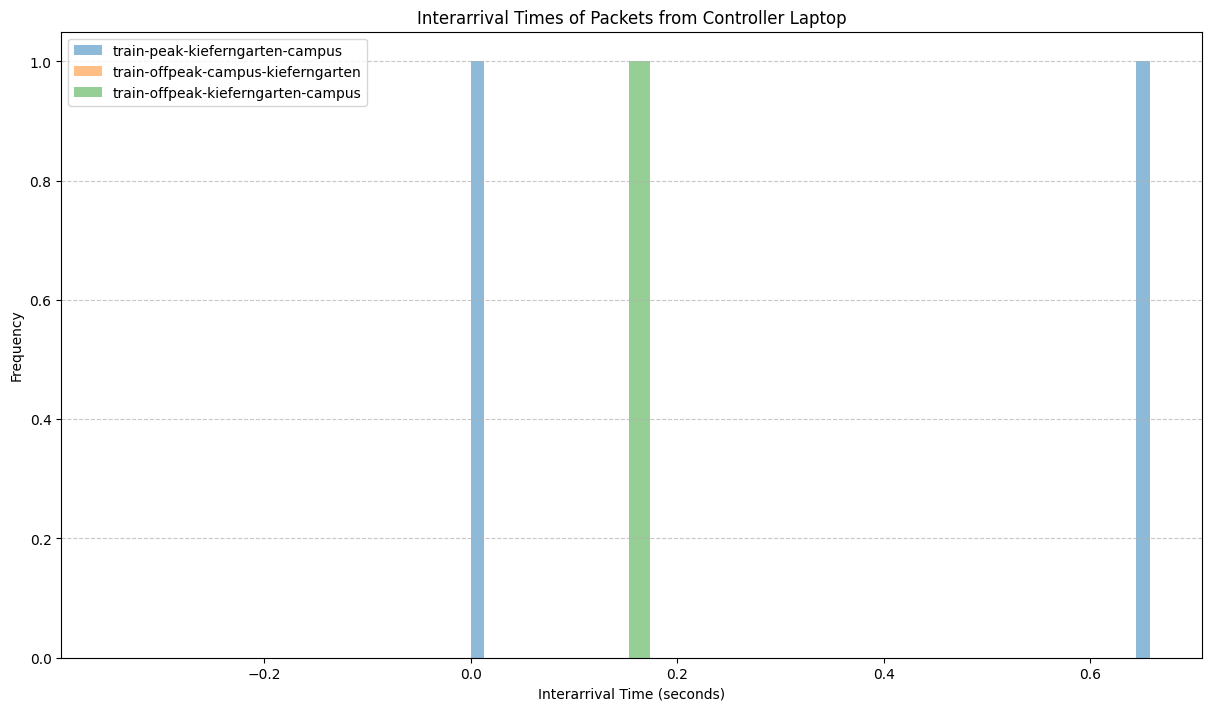

In [25]:
fig, ax = plt.subplots(figsize=(12, 7), constrained_layout=True)
for scenario in scenarios:
    controller_mac = [mac for mac in known_macs.keys() if "Controller Laptop" in known_macs[mac]][0]
    interarrival_times = []
    for channel in channels:
        for packet in packets[scenario][channel]:
            if packet["src_mac"] == controller_mac and packet["time"] is not None:
                interarrival_times.append(packet["time"])
    if len(interarrival_times) < 2:
        continue
    interarrival_times = np.diff(np.sort(interarrival_times))
    ax.hist(interarrival_times, bins=50, alpha=0.5, label=scenario)
ax.set_xlabel("Interarrival Time (seconds)")
ax.set_ylabel("Frequency")
ax.set_title("Interarrival Times of Packets from Controller Laptop")
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

start_time: 1751644924, end_time: 1751645584, num_bins: 660 for scenario train-peak-campus-kieferngarten


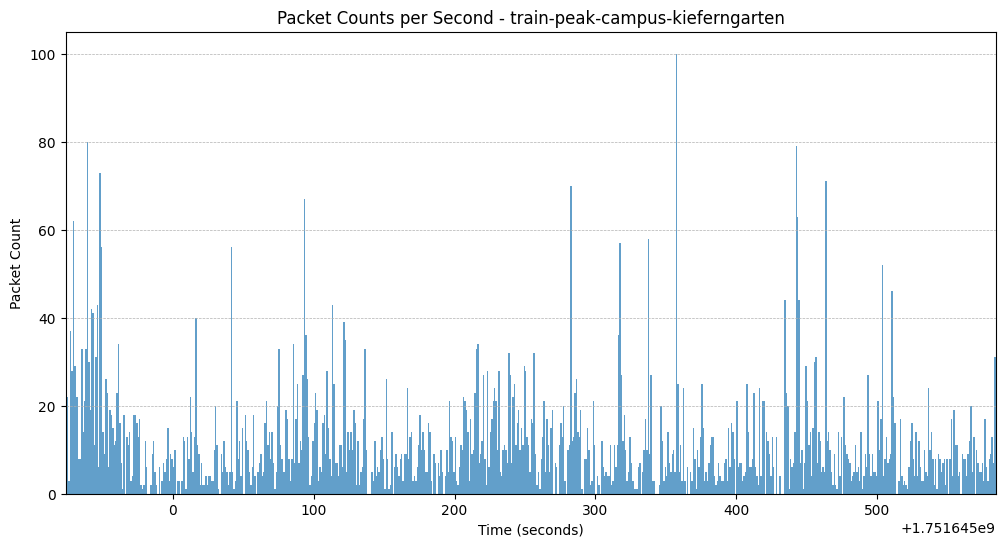

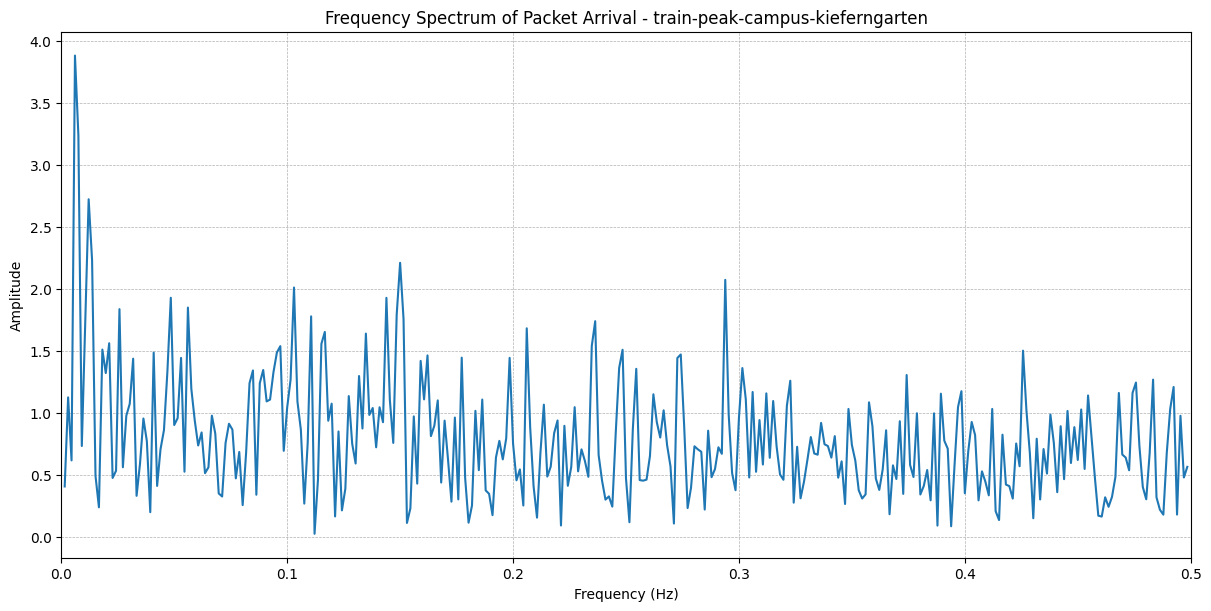

start_time: 1751647590, end_time: 1751648282, num_bins: 692 for scenario train-peak-kieferngarten-campus


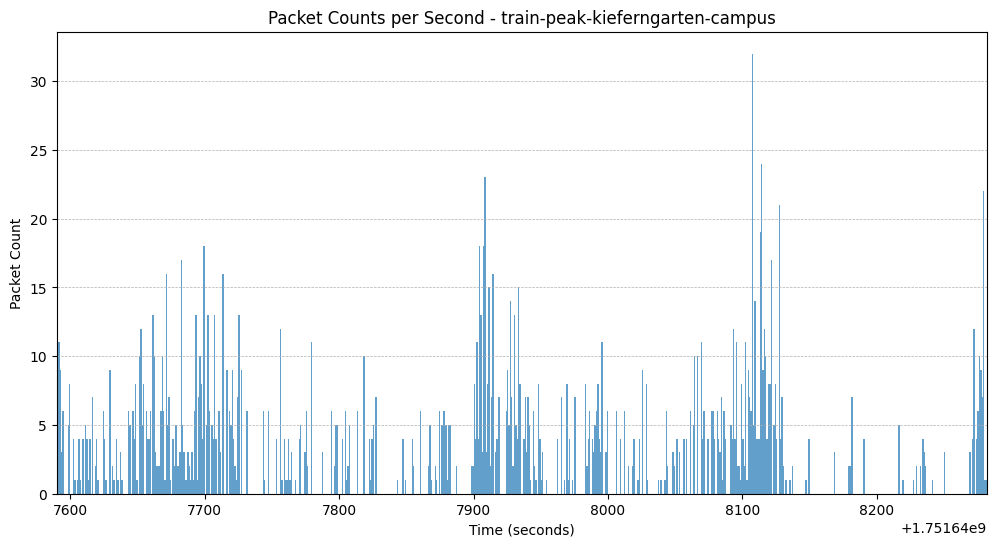

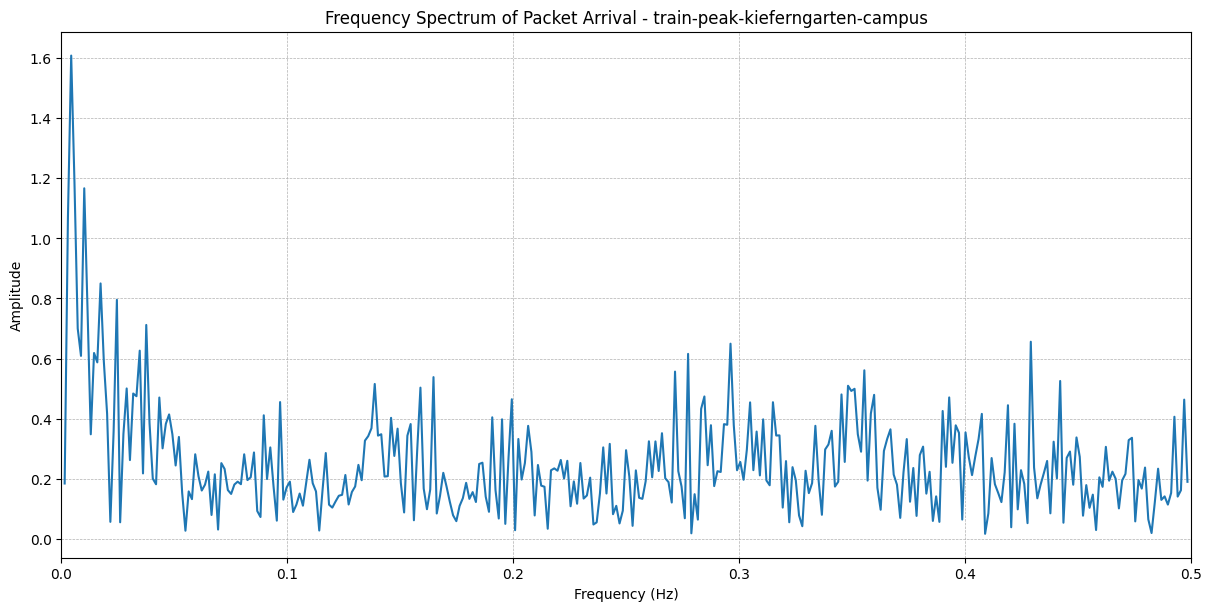

start_time: 1751819499, end_time: 1751820116, num_bins: 617 for scenario train-offpeak-campus-kieferngarten


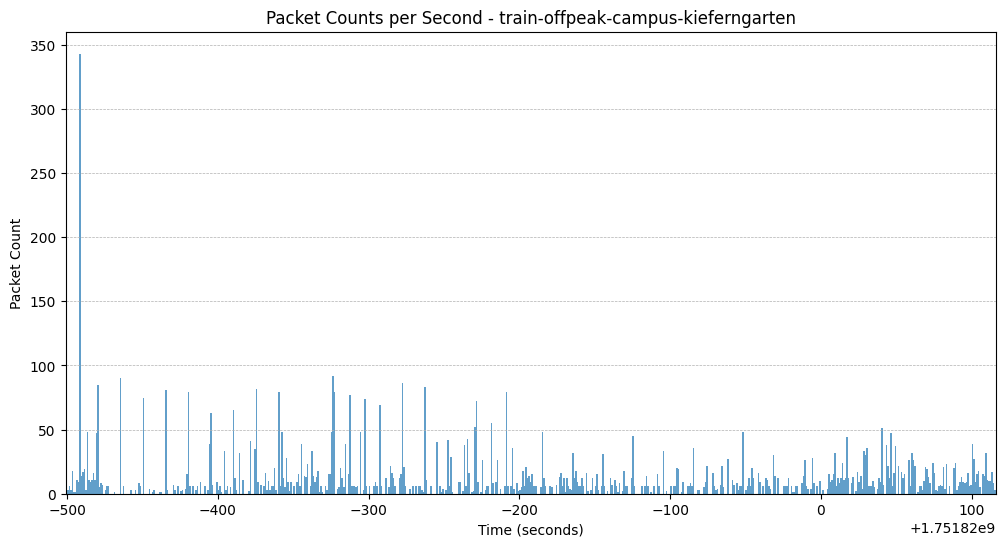

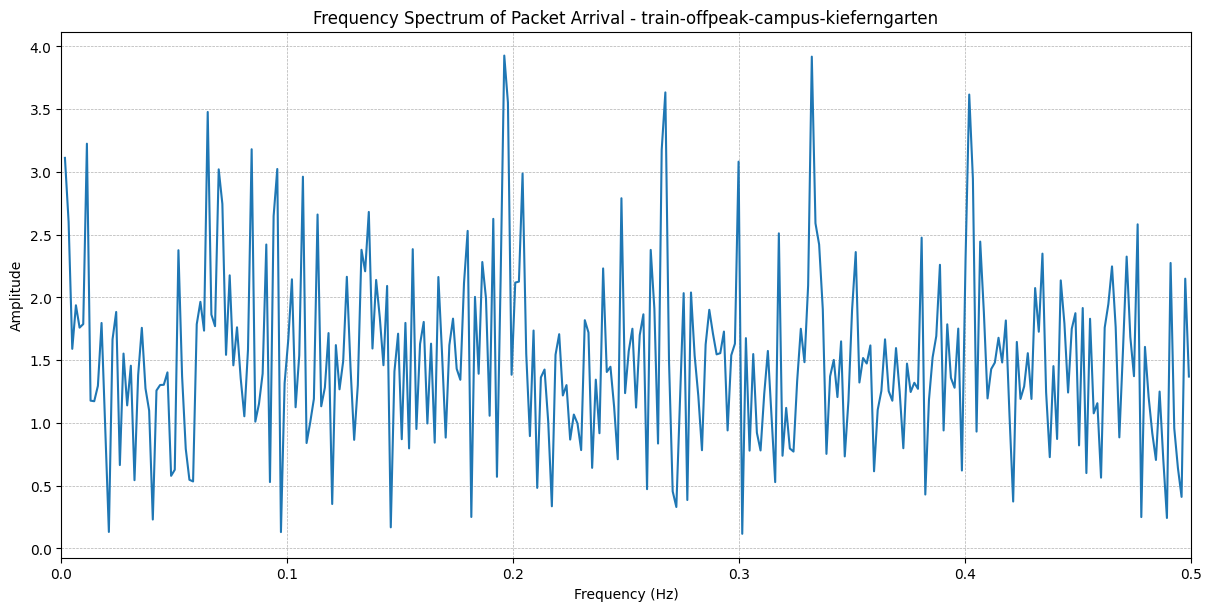

start_time: 1751822971, end_time: 1751823657, num_bins: 686 for scenario train-offpeak-kieferngarten-campus


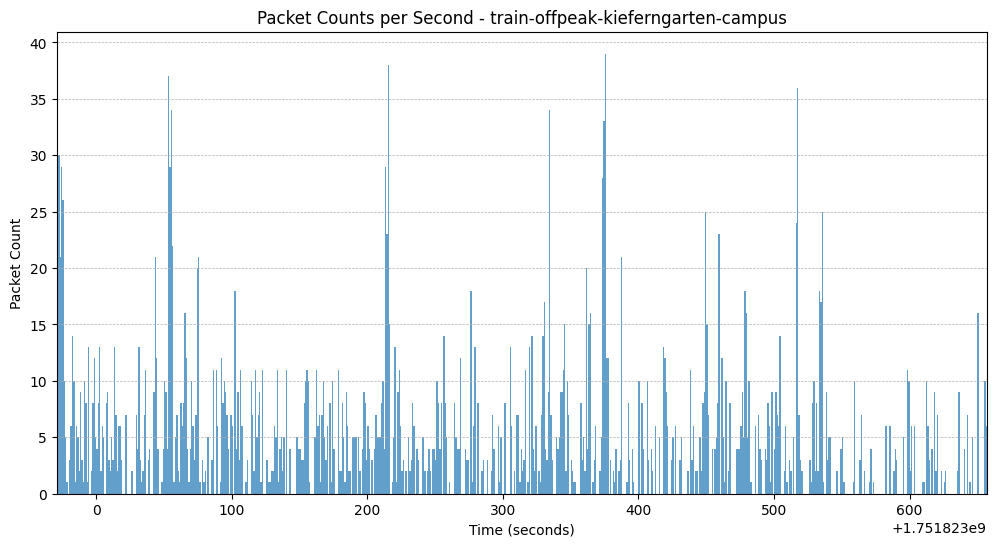

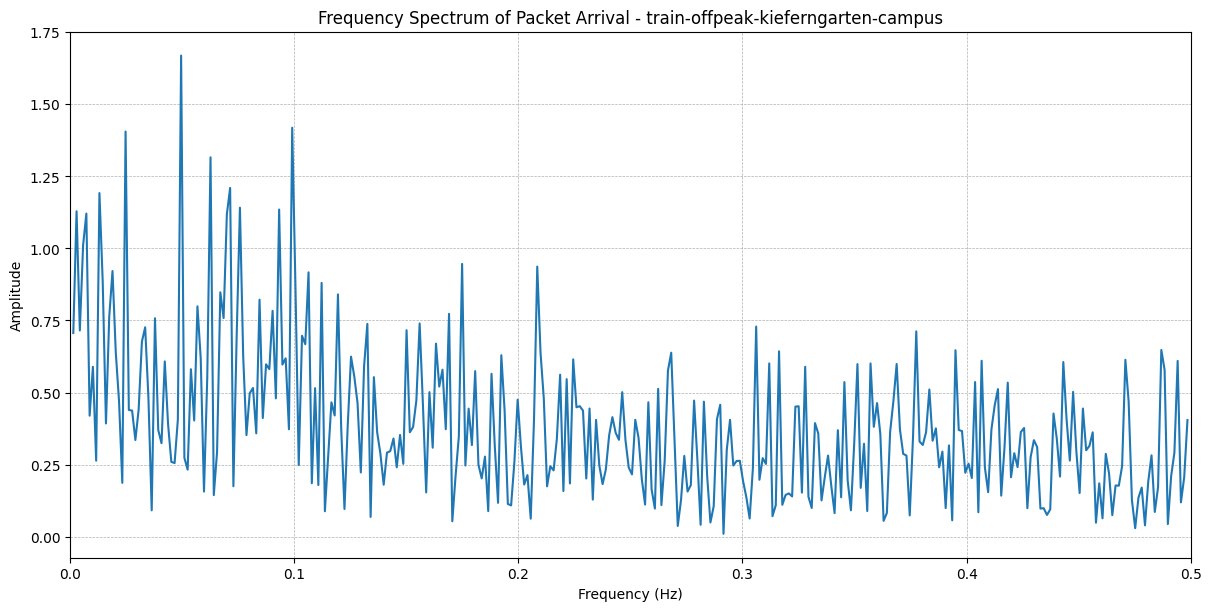

In [ ]:
for scenario in scenarios:
    all_times = []
    for channel in channels:
        all_times.extend([p['time'] for p in packets[scenario][channel]])
    
    if not all_times:
        continue

    all_times = np.array(all_times)
    
    sampling_rate = 1.0  # Hz
    start_time = np.floor(all_times.min())
    end_time = np.ceil(all_times.max())
    num_bins = int((end_time - start_time) * sampling_rate)
    print(f"start_time: {start_time}, end_time: {end_time}, num_bins: {num_bins} for scenario {scenario}")
    
    if num_bins < 2:
        continue
        
    time_bins = np.linspace(start_time, end_time, num_bins + 1)
    packet_counts, _ = np.histogram(all_times, bins=time_bins)

    plt.figure(figsize=(12, 6))
    plt.bar(time_bins[:-1], packet_counts, width=np.diff(time_bins), align='edge', alpha=0.7)
    plt.title(f"Packet Counts per Second - {scenario}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Packet Count")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.xlim(start_time, end_time)
    plt.show()
    
    N = len(packet_counts)
    yf = np.fft.fft(packet_counts)
    xf = np.fft.fftfreq(N, d=1/sampling_rate)
    
    fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
    
    positive_freq_mask = xf > 0
    ax.plot(xf[positive_freq_mask], 2.0/N * np.abs(yf[positive_freq_mask]))
    
    ax.set_title(f"Frequency Spectrum of Packet Arrival - {scenario}")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(0, sampling_rate / 2)
    plt.show()

In [ ]:
for scenario in scenarios:
    start_times = []
    durations = []
    for channel in channels:
        if channel != 6:
            continue
        times = channel_times[scenario][channel]
        if times:
            start_time = datetime.fromtimestamp(float(times[0]))
            end_time = datetime.fromtimestamp(float(times[-1]))
            start_times.append(start_time)
            durations.append((end_time - start_time).total_seconds())
    
    if not start_times or not durations:
        continue
    
    earliest_start = min(start_times)
    total_duration = sum(durations)
    
    print(f"Scenario: {scenario}")
    print(f"  Earliest Start Time: {earliest_start.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Total Duration: {int(total_duration // 60)}:{int(total_duration % 60)}")

Scenario: train-peak-campus-kieferngarten
  Earliest Start Time: 2025-07-04 18:02:05
  Total Duration: 10:58
Scenario: train-peak-kieferngarten-campus
  Earliest Start Time: 2025-07-04 18:46:30
  Total Duration: 11:30
Scenario: train-offpeak-campus-kieferngarten
  Earliest Start Time: 2025-07-06 18:31:39
  Total Duration: 10:15
Scenario: train-offpeak-kieferngarten-campus
  Earliest Start Time: 2025-07-06 19:29:31
  Total Duration: 11:24


In [28]:
print("\\begin{table}[ht]")
print("    \\centering")
print("    \\resizebox{\\columnwidth}{!}{")
print("    \\begin{tabular}{|l|c|c|c|}")
print("        \\hline")
print("        Scenario & Packet Count & Mean RSSI (dBm) & Std Dev RSSI (dBm) \\\\")
print("        \\hline")
for scenario_name, scenario in scenarios.items():
    packets_all = [pkt for ch in channels for pkt in packets[scenario_name][ch]]
    packet_count = len(packets_all)
    rssi_values = [pkt["dBm_AntSignal"] for pkt in packets_all if pkt["dBm_AntSignal"] is not None]
    mean_rssi = np.mean(rssi_values) if rssi_values else ""
    std_rssi = np.std(rssi_values) if rssi_values else ""
    print(f"        {scenario_name} & {packet_count} & {mean_rssi:.2f} & {std_rssi:.2f} \\\\")
    print("        \\hline")
print("    \\end{tabular}")
print("    }")
print("    \\caption{Overview of Probe Frame Counts, and RSSI Distribution}")
print("    \\label{tab:probe_frame_overview}")
print("\\end{table}")

\begin{table}[ht]
    \centering
    \resizebox{\columnwidth}{!}{
    \begin{tabular}{|l|c|c|c|}
        \hline
        Scenario & Packet Count & Mean RSSI (dBm) & Std Dev RSSI (dBm) \\
        \hline
        train-peak-campus-kieferngarten & 7654 & -48.61 & 11.67 \\
        \hline
        train-peak-kieferngarten-campus & 1840 & -53.94 & 11.99 \\
        \hline
        train-offpeak-campus-kieferngarten & 6737 & -60.13 & 7.18 \\
        \hline
        train-offpeak-kieferngarten-campus & 3202 & -54.24 & 11.35 \\
        \hline
    \end{tabular}
    }
    \caption{Overview of Probe Frame Counts, and RSSI Distribution}
    \label{tab:probe_frame_overview}
\end{table}


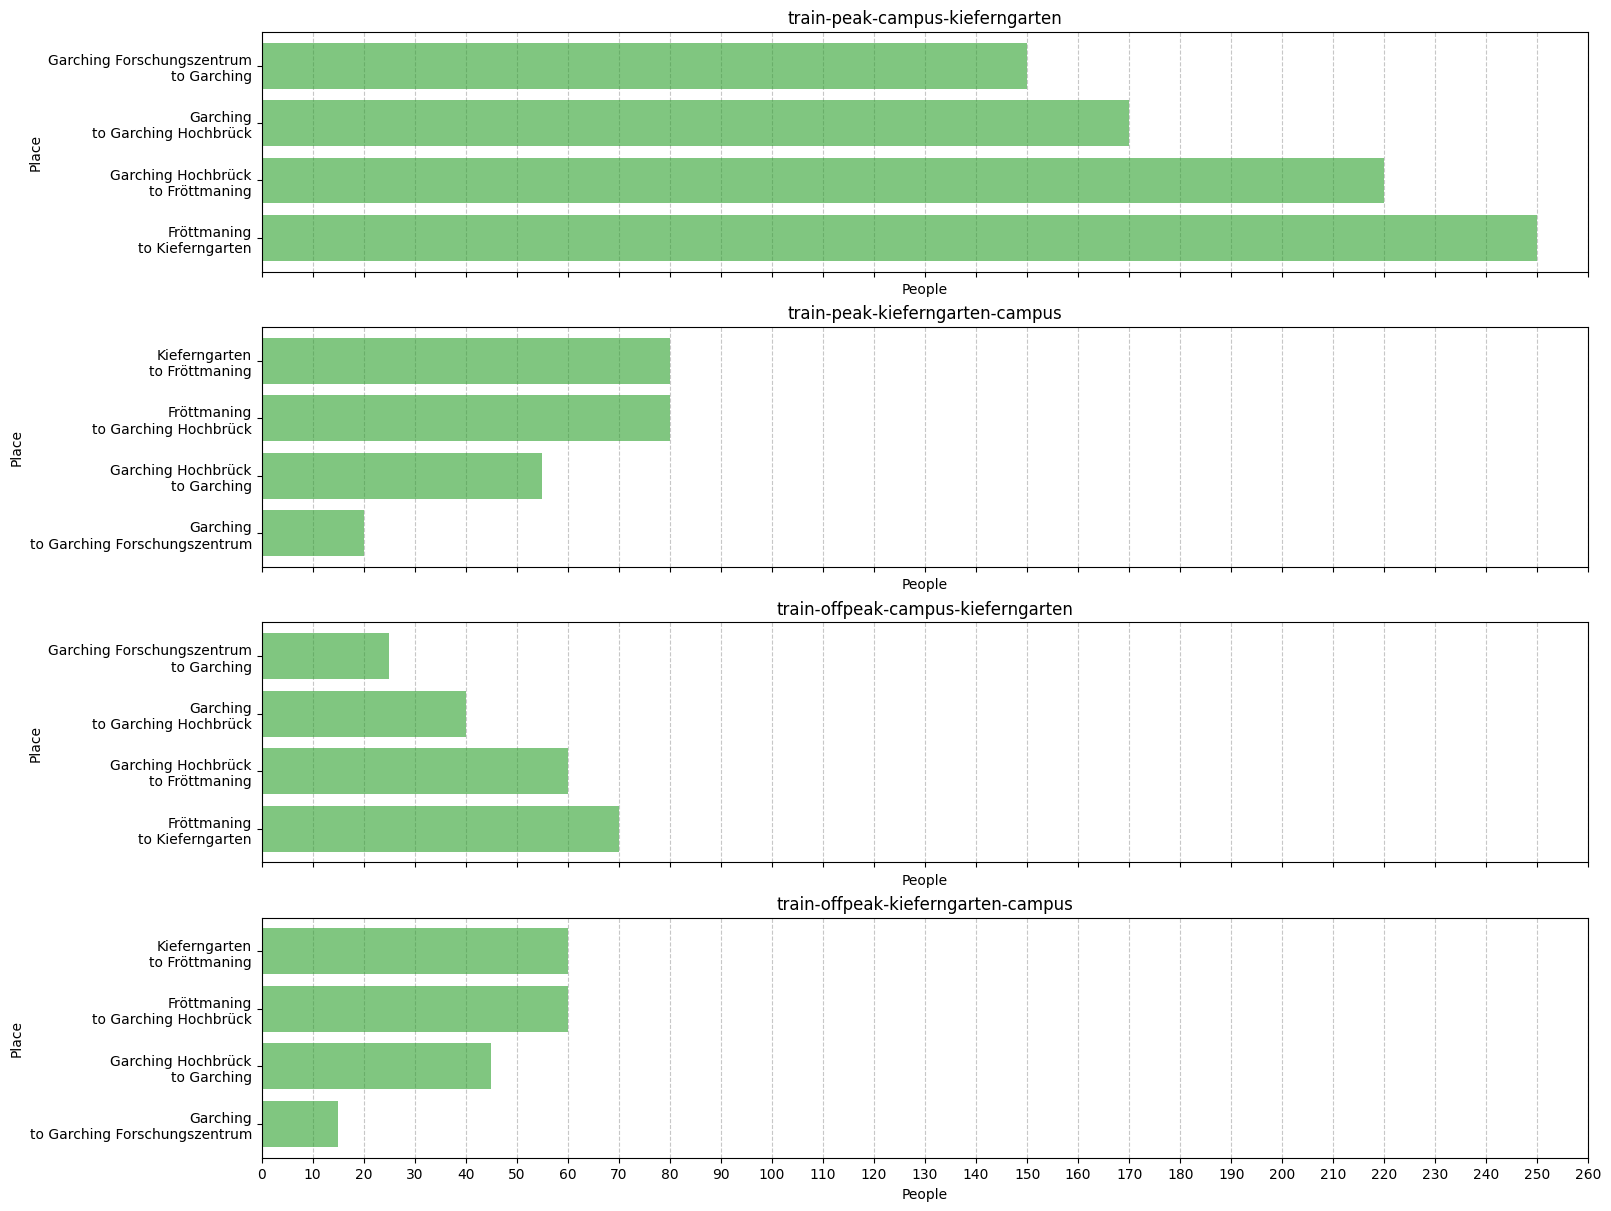

In [ ]:
crowd_estimates = {
    scenario: util.parse_crowd_estimate(
        captures_dir / f"{scenarios[scenario]['date']}/{scenario}-estimate.csv"
    )
    for scenario in scenarios
}

fig, axes = plt.subplots(4, 1, figsize=(16, 12), constrained_layout=True, sharex=True)
max_crowd = 0
for scenario, estimates in crowd_estimates.items():
    for entry in estimates:
        if entry["estimate"] != "-":
            max_crowd = max(max_crowd, int(entry["estimate"]))

for idx, (scenario, estimates) in enumerate(crowd_estimates.items()):
    ax = axes[idx]
    ax.set_title(scenario)
    places = []
    crowds = []
    for entry in estimates:
        if entry["estimate"] == "-":
            continue
        places.append(entry["place"].replace("\\n", "\n"))
        crowds.append(int(entry["estimate"]))
    ax.barh(places, crowds, color="tab:green", alpha=0.6, zorder=2)
    ax.set_xlabel("People")
    ax.set_ylabel("Place")
    ax.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)
    ax.set_xlim(0, ((max_crowd // 10) + 1) * 10)
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.invert_yaxis()

plt.savefig("../report/images/part1/crowd-estimations/crowd-estimate-trains.png", dpi=300, bbox_inches='tight')
plt.show()